<a href="https://colab.research.google.com/github/Qiustander/Simple_MCMC_tasks/blob/main/MCMC_For_MA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>.
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
In summary, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

#### References:
[1] Bayesian Data Analysis 3rd

[2] [Several MCMC convergence tools](https://colab.research.google.com/github/bebi103b/bebi103b.github.io/blob/master/lessons/16/mcmc_diagnostics.ipynb#scrollTo=0chfn87t4plw)



In [ ]:
#@title Imports and Global Variables  { display-mode: "form" }
"""Import necessary packages and set global variables
"""
!pip3 install -q pandas_datareader
!pip3 install -q wget
!pip3 install statsmodels
from __future__ import absolute_import, division, print_function

import numpy as np
import os
import statsmodels.api as sm
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib as mpl
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

def credible_interval(posterior_dist, alpha=0.05):
    """
    Compute the credible interval for a set of samples.

    Parameters:
    - posterior_dist: array-like, the set of samples
    - alpha: float, desired significance level (e.g., 0.05 for 95% credible interval)

    Returns:
    - tuple containing the lower and upper bounds of the credible interval
    """
    sorted_samples = np.sort(posterior_dist)
    lower_bound = np.percentile(sorted_samples, 100 * alpha / 2)
    upper_bound = np.percentile(sorted_samples, 100 * (1 - alpha / 2))

    return (lower_bound, upper_bound)


from tensorflow_probability.python.mcmc import RandomWalkMetropolis
from tensorflow_probability.python.mcmc import HamiltonianMonteCarlo
from tensorflow_probability.python.mcmc import sample_chain

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')


  Preparing metadata (setup.py) ... done
TnesorFlow version: 2.12.0
TnesorFlow Probability version: 0.20.1


# MCMC For Fitting MA(1)

General Moving Average (MA) model: $x_t = \delta + \sum_{i=1}^p\theta_i  ϵ_{t-i} + ϵ_t$, where $\delta$ is the intercept of the AR model. $\theta_i, i = 1, \dots, p$ denotes the white noise. In this problem, the $ϵ_t$ is assumed to be the normal distribution that $ϵ_t \sim \mathcal{N}(0, \sigma^2)$.

Problem: estimate the posterior distributions of unknowns $\sigma^2, \delta$, and $\theta$ in the MA(1) model. We assume the MA(1) model is invertible. That is, $|\theta| < 1$.

We can derive the mean of the MA(1) from the stationary condtion:
\begin{align}
&\mathbb{E}[x_t] = \delta +  \theta\mathbb{E}[ϵ_{t-1}] + \mathbb{E}[ϵ_{t}]\\
& ⇔ \mathbb{E}[x_t] = \delta.
\end{align}
Similarly, the variance of the MA(1) model is
\begin{align}
&Var(x_t) =  \theta^2 Var(ϵ_{t-1}) + Var(ϵ_{t})\\
& ⇔ Var(x_t) = (1+ \theta^2) \sigma^2.
\end{align}


## Estimation of unknown $\sigma^2, \delta$, and $\theta$

First of all, we assume that the $ϵ_{0}=0$. Therefore, $x_1 = \delta + ϵ_{1} + \theta ϵ_{0} \sim \mathcal{N}(\delta, \sigma^2)$.

Define the data likelihood function $l(\mathbf{x}| \sigma^2, \delta, \theta) = \mathcal{N}(x_1| \delta +\theta ϵ_{0}, \sigma^2)\prod_{t=2} \mathcal{N}(x_t|  \delta + \theta ϵ_{t-1}, \sigma^2)  = \prod_{t=1} \mathcal{N}(x_t|  \delta + \theta ϵ_{t-1}, \sigma^2)$ where each point follows the normal distribution, as stated above. It is worth noting that $ϵ_{t-1}$ and $ϵ_{t}$ are actually hidden variables, we need to recursively calculate them starting from $x_1$.

Assume $ϵ_{0} = 0$, then calculate $\hat{ϵ}_{1} = x_1 - \delta$. The $\hat{(\cdot)}$ is used to represent the estimated value. Similarly, $\hat{ϵ}_{2} = x_2 - \delta - \theta \hat{ϵ}_{1}$. All estimated $\hat{ϵ}$ can be calculated.



For $\theta$, we define the prior distribution as $\pi(\theta) \sim \mathcal{U}(-1, 1)$ which is the uniform distribution, for the  reason that $|\theta|< 1$.


For $\sigma$, we define the prior distribution as a inverse-Gamma distribution $\pi(\sigma^2) \sim \mathcal{IG}(\alpha, \beta)$.

For the constant drift $\delta$, we define  the prior distribution as the normal distribution $\pi(\delta) \sim \mathcal{N}(\mu_{\delta}, \sigma_{\delta}^2)$.


Therefore, the joint posterior distribution $p(\sigma^2, \delta, \theta|\mathbf{x}) ∝ l(\mathbf{x}| \sigma^2, \delta, \theta)  \pi(\sigma^2)\pi(\delta)\pi(\theta)$. We need to be careful that $\sigma^2$ is non-negative, and $\varphi$ must be inside $(-1, 1)$.

In [ ]:
#@title Data Generation  { run: "auto" }

# Set seed
seed = 132
tf.random.set_seed(seed=seed)
# Number of samples.
n = 100

# True parameters
def_theta = 0.6 # @param {type:"slider", min:-0.95, max:0.95, step:0.05}
true_theta = tf.constant([def_theta])

def_delta = -0.6 # @param {type:"slider", min:-3.0, max:3.0, step:0.1}
true_delta = tf.constant([[def_delta]])

def_noise_std = 1.2 # @param {type:"slider", min:0.1, max:6.0, step:0.5}
true_noise_std = tf.constant([[def_noise_std]])


# Generate samples, starting from stationary distribution
observations = []
current_innovation = tf.constant([0.])
innovations = []
innovations.append(current_innovation)

for i in range(n):
    xt = current_innovation*true_theta
    current_innovation = tfd.MultivariateNormalTriL(loc=tf.constant([0.]),
                                            scale_tril=true_noise_std).sample(seed=seed)
    innovations.append(current_innovation)
    observations.append(true_delta + xt + current_innovation)

observations = tf.concat(observations, axis=0)
innovations = tf.concat(innovations, axis=0)[:-1][..., tf.newaxis]

true_mean = true_delta
true_std = true_noise_std/tf.sqrt(1-true_theta**2)
sample_mean = tf.reduce_mean(observations)
sample_std = tf.math.reduce_std(observations)

print(f'sample mean: {sample_mean}')
print(f'sample std: {sample_std}')
print(f'true mean: {true_mean}')
print(f'true std: {true_std}')

PRIOR_MEAN_DELTA = tf.constant([1.0])
PRIOR_STD_DELTA = tf.constant([[0.8]])
PRIOR_INV_GAMMA_ALPHA = tf.constant([2.0])
PRIOR_INV_GAMMA_BETA= tf.constant([2.0])



sample mean: -0.38223162293434143
sample std: 1.3468093872070312
true mean: [[-0.6]]
true std: [[1.5]]


In [ ]:
#@title Define Conditional Sampling Class { display-mode: "form" }

"""Define Conditional Sampling Class
"""
import collections
from tensorflow_probability.python.mcmc.internal import util as mcmc_util
from tensorflow_probability.python.internal import unnest
from tensorflow_probability.python.internal import prefer_static
from tensorflow_probability.python.internal import samplers
from tensorflow_probability.python.internal import tensorshape_util
from tensorflow_probability.python.internal import distribute_lib

mcmc = tfp.mcmc  # pylint: disable=no-member

class SamplingKernelResults(
    mcmc_util.PrettyNamedTupleMixin,
    collections.namedtuple(
        "SamplingKernelResults",
        [
            "target_log_prob",
            "seed",
        ],
    ),
):
    __slots__ = ()


class SamplingKernel(mcmc.TransitionKernel):
    """Minimal conditional sampling Kernel based on specific
    """

    def __init__(self,
                 target_log_prob_fn,
                 current_full_states,
                 full_cond_dist,
                 sampling_idx,
                 experimental_shard_axis_names=None,
                 name=None):

        self._target_log_prob_fn = target_log_prob_fn
        self._sampling_idx = sampling_idx
        self._name = name
        self._parameters = dict(
            target_log_prob_fn=target_log_prob_fn,
            current_full_states=current_full_states,
            experimental_shard_axis_names=experimental_shard_axis_names,
            full_cond_dist=full_cond_dist,
            sampling_idx=sampling_idx,
            name=name)

    @property
    def sampling_idx(self):
        return self._parameters['sampling_idx']

    @property
    def target_log_prob_fn(self):
        return self._parameters['target_log_prob_fn']

    @property
    def current_full_states(self):
        return self._parameters['current_full_states']

    @property
    def full_cond_dist(self):
        return self._parameters['full_cond_dist']

    @property
    def name(self):
        return self._parameters['name']

    @property
    def parameters(self):
        """Return `dict` of ``__init__`` arguments and their values."""
        return self._parameters

    @property
    def is_calibrated(self):
        return False

    def one_step(self, current_state, previous_kernel_results, seed=None):
        with tf.name_scope(mcmc_util.make_name(self.name, 'cond_sampling', 'one_step')):
            with tf.name_scope('initialize'):
                if mcmc_util.is_list_like(current_state):
                    current_state_parts = list(current_state)
                else:
                    current_state_parts = [current_state]
                current_state_parts = [
                    tf.convert_to_tensor(s, name='current_state')
                    for s in current_state_parts
                ]

            seed = samplers.sanitize_seed(seed)  # Retain for diagnostics.
            state_fn_kwargs = {}
            if self.experimental_shard_axis_names is not None:
                state_fn_kwargs['experimental_shard_axis_names'] = (
                    self.experimental_shard_axis_names)

            next_state_parts = self.full_cond_dist(current_state=current_state_parts, # pylint: disable=not-callable
                state_parts=self.current_full_states, seed=seed, sampling_idx=self._sampling_idx)

            # User should be using a new_state_fn that does not alter the state size.
            # This will fail noisily if that is not the case.
            for next_part, current_part in zip(next_state_parts, self.current_full_states):
                tensorshape_util.set_shape(next_part, current_part.shape)

            # Compute `target_log_prob` so its available to MetropolisHastings.
            next_target_log_prob = self.target_log_prob_fn(next_state_parts[self.sampling_idx])  # pylint: disable=not-callable

            return [
                next_state_parts[self.sampling_idx],
                SamplingKernelResults(
                    target_log_prob=next_target_log_prob,
                    seed=seed,
                ),
            ]

    def bootstrap_results(self, init_state):
        with tf.name_scope(mcmc_util.make_name(
                self.name, 'cond_sampling', 'bootstrap_results')):
            if not mcmc_util.is_list_like(init_state):
                init_state = [init_state]
            init_state = [tf.convert_to_tensor(x) for x in init_state]
            init_target_log_prob = self.target_log_prob_fn(*init_state)  # pylint:disable=not-callable
            return SamplingKernelResults(
                target_log_prob=init_target_log_prob,
                # Allow room for one_step's seed.
                seed=samplers.zeros_seed())

    @property
    def experimental_shard_axis_names(self):
        return self._parameters['experimental_shard_axis_names']

    def experimental_with_shard_axes(self, shard_axis_names):
        return self.copy(experimental_shard_axis_names=shard_axis_names)


def cond_sample_fn(inner_sample_dist):
    """ Conditional sampling function which samples from inner_sample_dist
    """

    def _fn(current_state,
            state_parts,
            seed,
            sampling_idx,
            name=None,
            experimental_shard_axis_names=None):
        with tf.name_scope(name or 'ful_cond_fn'):
            part_seeds = list(samplers.split_seed(seed, n=len(state_parts)))
            part_seeds = distribute_lib.fold_in_axis_index(
                part_seeds, experimental_shard_axis_names)

            state_parts = [
                tf.convert_to_tensor(s, name="current_state") for s in state_parts
            ]

            sample_state = state_parts[sampling_idx]
            state_parts.pop(sampling_idx)

            # sometimes sample_state is not necessary, but useful in most cases
            updated_state = inner_sample_dist(sampling_idx, sample_state, state_parts, part_seeds[sampling_idx])

            state_parts.insert(sampling_idx, updated_state)

        return state_parts

    return _fn


In [ ]:
#@title Define Gibbs Kernel Class { display-mode: "form" }

"""Define Gibbs Sampling Class
"""
"""Gibbs sampling kernel"""


class GibbsKernelResults(
    mcmc_util.PrettyNamedTupleMixin,
    collections.namedtuple(
        "GibbsKernelResults",
        [
            "target_log_prob",
            "inner_results",
            "step",
        ],
    ),
):
    __slots__ = ()


def _flatten_results(results):
    """Results structures from nested Gibbs samplers sometimes
    need flattening for writing out purposes.
    """

    def recurse(r):
        for i in iter(r):
            if isinstance(i, list):
                for j in _flatten_results(i):
                    yield j
            else:
                yield i

    return [r for r in recurse(results)]


def _has_gradients(results):
    return unnest.has_nested(results, "grads_target_log_prob")


def _get_target_log_prob(results):
    """Fetches a target log prob from a results structure"""
    return unnest.get_innermost(results, "target_log_prob")


def _update_target_log_prob(results, target_log_prob):
    """Puts a target log prob into a results structure"""
    if isinstance(results, GibbsKernelResults):
        replace_fn = unnest.replace_outermost
    else:
        replace_fn = unnest.replace_innermost
    return replace_fn(results, target_log_prob=target_log_prob)


def _maybe_transform_value(tlp, state, kernel, direction):
    if not isinstance(kernel, tfp.mcmc.TransformedTransitionKernel):
        return tlp

    tlp_rank = prefer_static.rank(tlp)
    event_ndims = prefer_static.rank(state) - tlp_rank

    if direction == "forward":
        return tlp + kernel.bijector.inverse_log_det_jacobian(
            state, event_ndims=event_ndims
        )
    if direction == "inverse":
        return tlp - kernel.bijector.inverse_log_det_jacobian(
            state, event_ndims=event_ndims
        )
    raise AttributeError("`direction` must be `forward` or `inverse`")


class GibbsKernel(mcmc.TransitionKernel):
    """Gibbs Sampling Algorithm.
    Gibbs sampling may be useful when the joint distribution is explicitly unknown
    or difficult to sample from directly, but the conditional distribution for each
    variable is known and can be sampled directly. The Gibbs sampling algorithm
    generates a realisation from each variable's conditional distribution in turn,
    conditional on the current realisations of the other variables.
    The resulting sequence of samples forms a Markov chain whose stationary
    distribution represents the joint distribution.

    """

    def __init__(self, target_log_prob_fn, kernel_list, name=None):
        """Build a Gibbs sampling scheme from component kernels.

        :param target_log_prob_fn: a function that takes `state` arguments
                                   and returns the target log probability
                                   density.
        :param kernel_list: a list of tuples `(state_part_idx, kernel_make_fn)`.
                            `state_part_idx` denotes the index (relative to
                            positional args in `target_log_prob_fn`) of the
                            state the kernel updates.  `kernel_make_fn` takes
                            arguments `target_log_prob_fn` and `state`, returning
                            a `tfp.mcmc.TransitionKernel`.
                            The length of the kernel list should be the same as the number of parameters
        :returns: an instance of `GibbsKernel`
        """
        # Require to check if all kernel.is_calibrated is True
        self._parameters = dict(
            target_log_prob_fn=target_log_prob_fn,
            kernel_list=kernel_list,
            name=name,
        )

    @property
    def is_calibrated(self):
        return True

    @property
    def target_log_prob_fn(self):
        return self._parameters["target_log_prob_fn"]

    @property
    def kernel_list(self):
        return self._parameters["kernel_list"]

    @property
    def name(self):
        return self._parameters["name"]

    def one_step(self, current_state, previous_results, seed=None):
        """We iterate over the state elements, calling each kernel in turn.

        The `target_log_prob` is forwarded to the next `previous_results`
        such that each kernel has a current `target_log_prob` value.
        Transformations are automatically performed if the kernel is of
        type tfp.mcmc.TransformedTransitionKernel.

        In graph and XLA modes, the for loop should be unrolled.
        """
        if mcmc_util.is_list_like(current_state):
            state_parts = list(current_state)
        else:
            state_parts = [current_state]
            # A list, containing all states in Tensor

        state_parts = [
            tf.convert_to_tensor(s, name="current_state") for s in state_parts
        ]

        next_results = []
        untransformed_target_log_prob = previous_results.target_log_prob

        for (state_part_idx, kernel_fn), previous_step_results in zip(
                self.kernel_list, previous_results.inner_results
        ):

            def target_log_prob_fn(state_part):
                # This function is defined before the update, so need extra step to update the state_parts
                state_parts[
                    state_part_idx  # pylint: disable=cell-var-from-loop
                ] = state_part

                # Update the latest index
                return self.target_log_prob_fn(*state_parts)

            # kernel_fn is the kernel_make_fn
            # The target_log_prob is computed after the update of the parameter
            kernel = kernel_fn(target_log_prob_fn, state_parts, state_part_idx)

            # Forward the current tlp to the kernel.  If the kernel is gradient-based,
            # we need to calculate fresh gradients, as these cannot easily be forwarded
            # from the previous Gibbs step.
            if _has_gradients(previous_step_results):
                fresh_previous_results = unnest.UnnestingWrapper(
                    kernel.bootstrap_results(state_parts[state_part_idx])
                )
                previous_step_results = unnest.replace_innermost(
                    previous_step_results,
                    target_log_prob=fresh_previous_results.target_log_prob,
                    grads_target_log_prob=fresh_previous_results.grads_target_log_prob,
                )

            else:
                previous_step_results = _update_target_log_prob(
                    previous_step_results,
                    _maybe_transform_value(
                        tlp=untransformed_target_log_prob,
                        state=state_parts[state_part_idx],
                        kernel=kernel,
                        direction="inverse",
                    ),
                )
            # For full conditional sampling, we need to pass the full states
            state_parts[state_part_idx], next_kernel_results = kernel.one_step(
                state_parts[state_part_idx], previous_step_results, seed
            )

            next_results.append(next_kernel_results)

            # Cache the new tlp for use in the next Gibbs step
            untransformed_target_log_prob = _maybe_transform_value(
                tlp=_get_target_log_prob(next_kernel_results),
                state=state_parts[state_part_idx],
                kernel=kernel,
                direction="forward",
            )
        return (
            state_parts
            if mcmc_util.is_list_like(current_state)
            else state_parts[0],
            GibbsKernelResults(
                target_log_prob=untransformed_target_log_prob,
                inner_results=next_results,  # All intermediate results are recorded, is it necessary? - Qiuliang
                step=1 + previous_results.step,
            ),
        )

    def bootstrap_results(self, current_state):

        if mcmc_util.is_list_like(current_state):
            state_parts = list(current_state)
        else:
            state_parts = [tf.convert_to_tensor(current_state)]
        state_parts = [
            tf.convert_to_tensor(s, name="current_state") for s in state_parts
        ]

        inner_results = []
        untransformed_target_log_prob = 0.0
        for state_part_idx, kernel_fn in self.kernel_list:
            def target_log_prob_fn(state_part):
                state_parts[
                    state_part_idx  # pylint: disable=cell-var-from-loop
                ] = state_part
                return self.target_log_prob_fn(*state_parts)

            kernel = kernel_fn(target_log_prob_fn, current_state, state_part_idx)
            kernel_results = kernel.bootstrap_results(
                state_parts[state_part_idx]
            )
            inner_results.append(kernel_results)
            untransformed_target_log_prob = _maybe_transform_value(
                tlp=_get_target_log_prob(kernel_results),
                state=state_parts[state_part_idx],
                kernel=kernel,
                direction="forward",
            )

        return GibbsKernelResults(
            target_log_prob=untransformed_target_log_prob,
            inner_results=inner_results,
            step=tf.constant(0, dtype=tf.int32),
        )


In [ ]:
num_mcmc_samples = 3000
num_burn_in_steps = int(num_mcmc_samples//2)
# The number of chains is determined by the shape of the initial values.
# Here we'll generate N_CHAINS chains, so we'll need a tensor of N_CHAINS initial values.
N_CHAINS = 1

# Replicate the observations for each chain
replicate_observations = tf.tile(tf.expand_dims(observations, axis=1), multiples=[1, N_CHAINS, 1])
replicate_innovations = tf.tile(tf.expand_dims(innovations, axis=1), multiples=[1, N_CHAINS, 1])

In [ ]:
"""
define prior distribution
"""
from tensorflow_probability.python.mcmc import TransformedTransitionKernel
# joint parameters - sigma, delta, theta

def prior_dist(parameter):
    return tfd.InverseGamma(concentration=PRIOR_INV_GAMMA_ALPHA,
                                    scale=PRIOR_INV_GAMMA_BETA).log_prob(parameter[..., 0]) + \
        tfd.MultivariateNormalTriL(loc=PRIOR_MEAN_DELTA, scale_tril=PRIOR_STD_DELTA).log_prob(parameter[..., 1:2]) + \
            tf.squeeze(tfd.Uniform(low=-0.99, high=0.99).log_prob(parameter[..., -1:]))

"""
define target distribution
"""
def posterior_dist(observations):
    def _compute_posterior(parameter):
        # use tf.vector_map to speed up

        estimated_noise = tf.scan(fn=lambda a, x: x - a * parameter[..., -1:] - parameter[..., 1:2],
                                elems=replicate_observations,
                                initializer=tf.zeros([N_CHAINS, 1]),
                                parallel_iterations=20)
        estimated_noise = tf.concat([tf.zeros([1, N_CHAINS, 1]), estimated_noise[:-1, ...]], axis=0)

        data_std = parameter[..., 0:1]
        likelihood = tfd.MultivariateNormalTriL(loc=parameter[..., -1:]*estimated_noise + parameter[..., 1:2],
                                                        scale_tril=data_std[..., tf.newaxis]).log_prob(observations)
        return tf.reduce_sum(likelihood, axis=0) + prior_dist(parameter)

    return _compute_posterior

"""
Sampling
"""
init_state = tf.concat([tf.random.uniform([N_CHAINS, 1]),
                        tf.random.normal([N_CHAINS, 1]),
                        tf.random.uniform([N_CHAINS, 1])-0.5], axis=-1)

unconstrained_to_original = tfb.Blockwise(
    bijectors=[tfb.Exp(), tfb.Identity()],
    block_sizes=[1, 2]
)

@tf.function
def run_metropolis_hasting():
  mh_kernel = RandomWalkMetropolis(posterior_dist(replicate_observations),
                                    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.2))

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start
                                        num_burnin_steps=num_burn_in_steps,
                                        num_steps_between_results=5,
                                        kernel=TransformedTransitionKernel(mh_kernel,
                                                                                    bijector=unconstrained_to_original),
                                        seed=seed)
  return states, kernels_results

@tf.function
def run_hmc():
  hmc_kernel = TransformedTransitionKernel(HamiltonianMonteCarlo(posterior_dist(replicate_observations),
                                    step_size=0.01,
                                    num_leapfrog_steps=3), bijector=unconstrained_to_original)
  adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=hmc_kernel,
    num_adaptation_steps=int(0.8 * num_burn_in_steps),
    target_accept_prob=0.651)

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start
                                        num_burnin_steps=num_burn_in_steps,
                                        kernel=adapted_kernel,
                                        seed=seed)

  return states, kernels_results

mh_states, mh_results = run_metropolis_hasting()
hmc_states, hmc_results = run_hmc()

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


#### Analytical Posterior Distribution

The posterior distribution of $\sigma^2$ is
$\mathcal{IG}\left(\alpha+\frac{n-1}{2}, \beta+\frac{\sum_{t=1}^n\left(x_t-(\theta \epsilon_{t-1} + \delta)\right)^2}{2}\right)$

The posterior distribution of $\theta$ is
$\mathcal{TN}\left( \frac{\sum_{t=1}^n \epsilon_{t-1}(x_t - \delta)}{\sum_{t=1}^n \epsilon_{t-1}^2}, \frac{1}{\sum_{t=1}^n\epsilon_{t-1}^2}\right)$, which is a truncated Normal defined in $(-1, 1)$.

The posterior distribution of $\delta$ is
$\mathcal{N}\left(\frac{1}{\frac{1}{\sigma_{\delta}^2}+\frac{n-1}{\sigma^2}}\left(\frac{\mu_{\delta}}{\sigma_{\delta}^2} + \frac{ \sum_{t=1}^n x_t-\theta \epsilon_{t-1} }{\sigma^2}\right), \left(\frac{1}{\sigma_{\delta}^2}+\frac{n-1}{\sigma^2}\right)^{-1}\right)$


In [ ]:
# @title Analytical Posterior Mean

coeff_delta = 1/PRIOR_STD_DELTA**2 + observations.shape[0]/sample_std**2
sum_xt2 = tf.reduce_sum(innovations**2, axis=0)
sum_xt = tf.reduce_sum(innovations*(observations-true_delta), axis=0)

#
true_posterior_mean_delta = 1/coeff_delta*\
 (tf.reduce_sum(observations - true_theta*innovations)/sample_std**2 + PRIOR_MEAN_DELTA/PRIOR_STD_DELTA**2)

true_posterior_mean_theta = sum_xt/sum_xt2

posterior_alpha = PRIOR_INV_GAMMA_ALPHA + observations.shape[0]//2
posterior_beta = PRIOR_INV_GAMMA_BETA + \
        tf.reduce_sum((observations - (true_theta*innovations+true_delta))**2, axis=0)//2
poster_dist  = tfd.InverseGamma(concentration=posterior_alpha,
                                  scale=posterior_beta)
true_posterior_sigma_mean = tf.sqrt(poster_dist.mean())
true_posterior_sigma_std = poster_dist.stddev()


In [ ]:
# @title Diagonics
def run_diag():
  r_hat_mh = tfp.mcmc.potential_scale_reduction(
      mh_states,
      independent_chain_ndims=1,
      split_chains=True)
  r_hat_hmc = tfp.mcmc.potential_scale_reduction(
      hmc_states,
      independent_chain_ndims=1,
      split_chains=True)

  print(f"R^hat for MH algorithm {r_hat_mh}")
  print(f"R^hat for HMC algorithm {r_hat_hmc}")

  accept_rate_mh = tf.math.count_nonzero(mh_results.inner_results.is_accepted, axis=0)/num_mcmc_samples
  accept_rate_hmc = tf.math.count_nonzero(hmc_results.inner_results.inner_results.is_accepted, axis=0)/num_mcmc_samples

  print(f"Acceptance rate for MH algorithm {accept_rate_mh}")
  print(f"Acceptance rate for HMC algorithm {accept_rate_hmc}")

  ess_mh = tfp.mcmc.effective_sample_size(
      mh_states,
      cross_chain_dims=None,
  )
  ess_hmc = tfp.mcmc.effective_sample_size(
      hmc_states,
      cross_chain_dims=None,
  )

  print(f"Effective sample size for MH algorithm {ess_mh}")
  print(f"Effective sample size for HMC algorithm {ess_hmc}")

run_diag()

R^hat for MH algorithm [0.9996673  1.0054804  0.99995244]
R^hat for HMC algorithm [1.0022601  0.99941945 0.9997692 ]
Acceptance rate for MH algorithm [0.17]
Acceptance rate for HMC algorithm [0.64466667]
Effective sample size for MH algorithm [[1299.9248  613.1228 1396.4766]]
Effective sample size for HMC algorithm [[ 543.886  1986.2745 2201.2505]]


In [ ]:
# use the first chain for plotting auto-correlation
# joint parameters - mu, sigma, delta, varphi

true_value = [true_noise_std, true_delta, true_theta]
posterior_value = [true_posterior_sigma_mean, true_posterior_mean_delta, true_posterior_mean_theta]

def plot_convergence(chain=1, state=0):
  sm.graphics.tsa.plot_acf(mh_states[:, chain, state],
                          title='Autocorrelation of MH algorithm',
                          lags=60)
  sm.graphics.tsa.plot_acf(hmc_states[:, chain, state],
                          title='Autocorrelation of HMC algorithm',
                          lags=60)

  # plot the fist chain

  mh_dist = mh_states[:, chain, state]
  hmc_dist = hmc_states[:, chain, state]

  # Scatter plot of data samples and histogram
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(111)
  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
  # lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
  ci_mh = credible_interval(mh_dist)
  ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
  ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
  ax.axvline(x=true_value[state], color='red', linestyle='-', label='true mean')
  ax.axvline(x=posterior_value[state], color='black', linestyle='-', label='true posterior mean')
  ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

  ax.legend(loc="best")
  ax.grid(True, zorder=-5)
  plt.show()


  # Scatter plot of data samples and histogram
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(111)
  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
  # lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
  ci_hmc = credible_interval(hmc_dist)
  ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
  ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
  ax.axvline(x=true_value[state], color='red', linestyle='-', label='true mean')
  ax.axvline(x=posterior_value[state], color='black', linestyle='-', label='true posterior mean')
  ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

  ax.legend(loc="best")
  ax.grid(True, zorder=-5)
  plt.show()

<ipython-input-9-30fd5d638ad5>:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


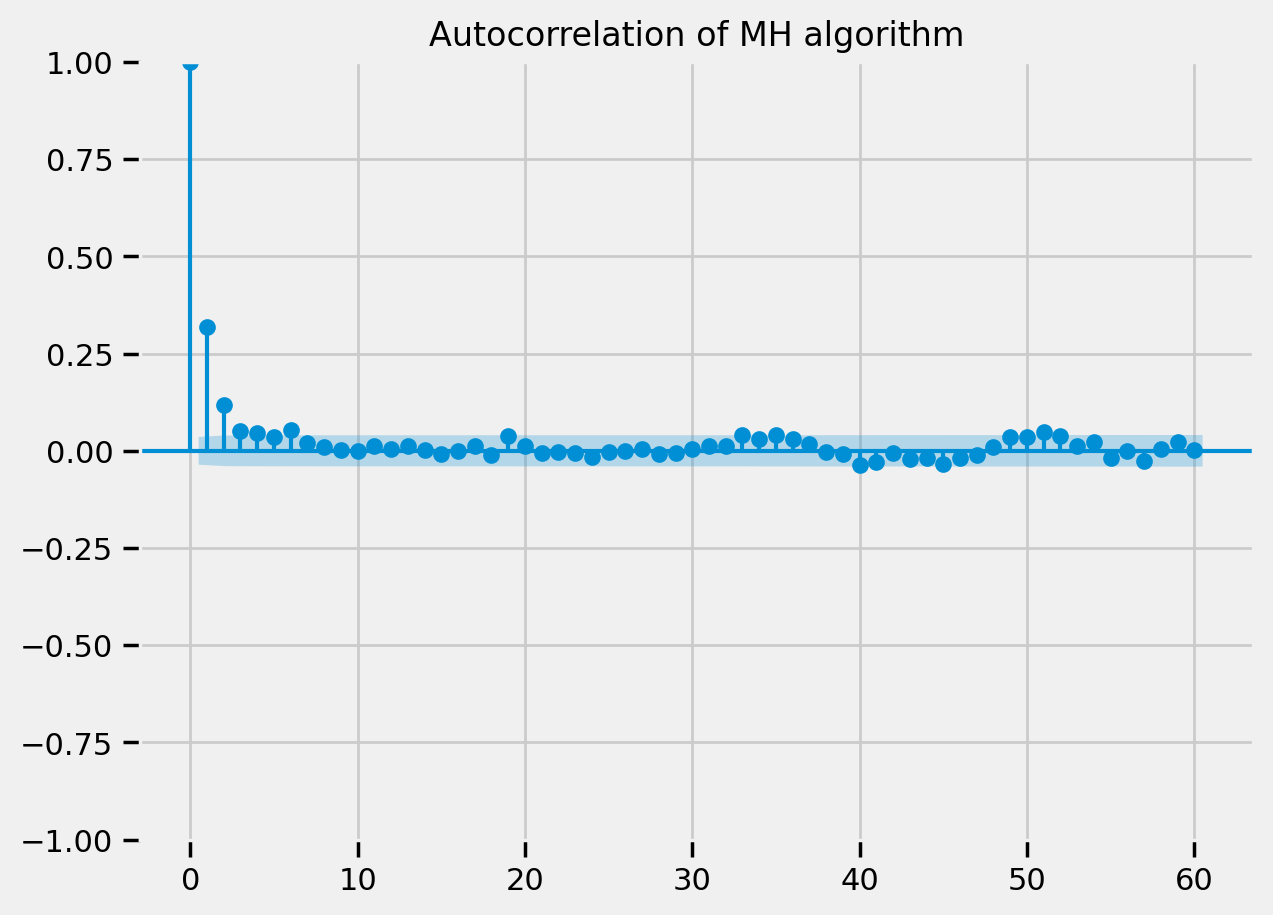

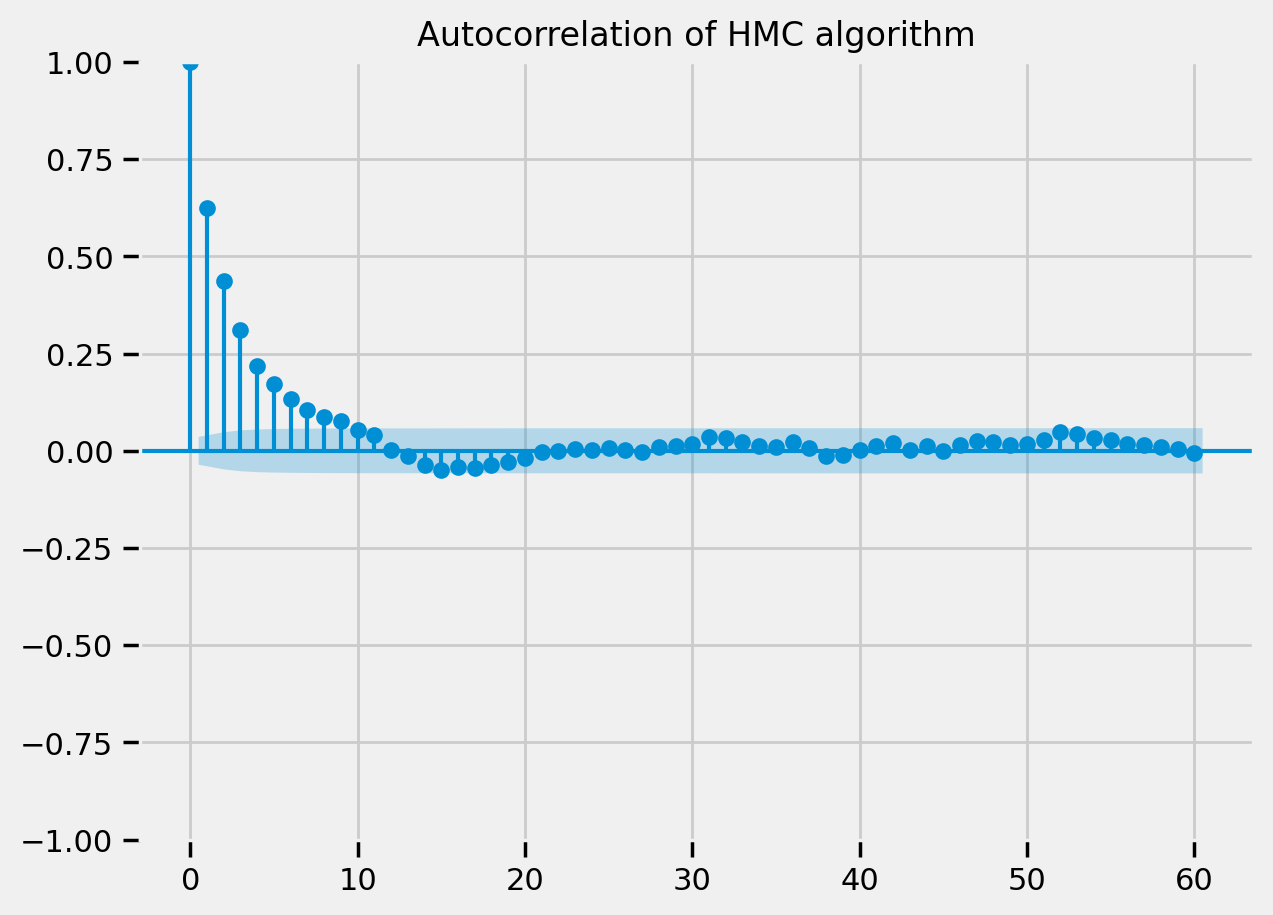

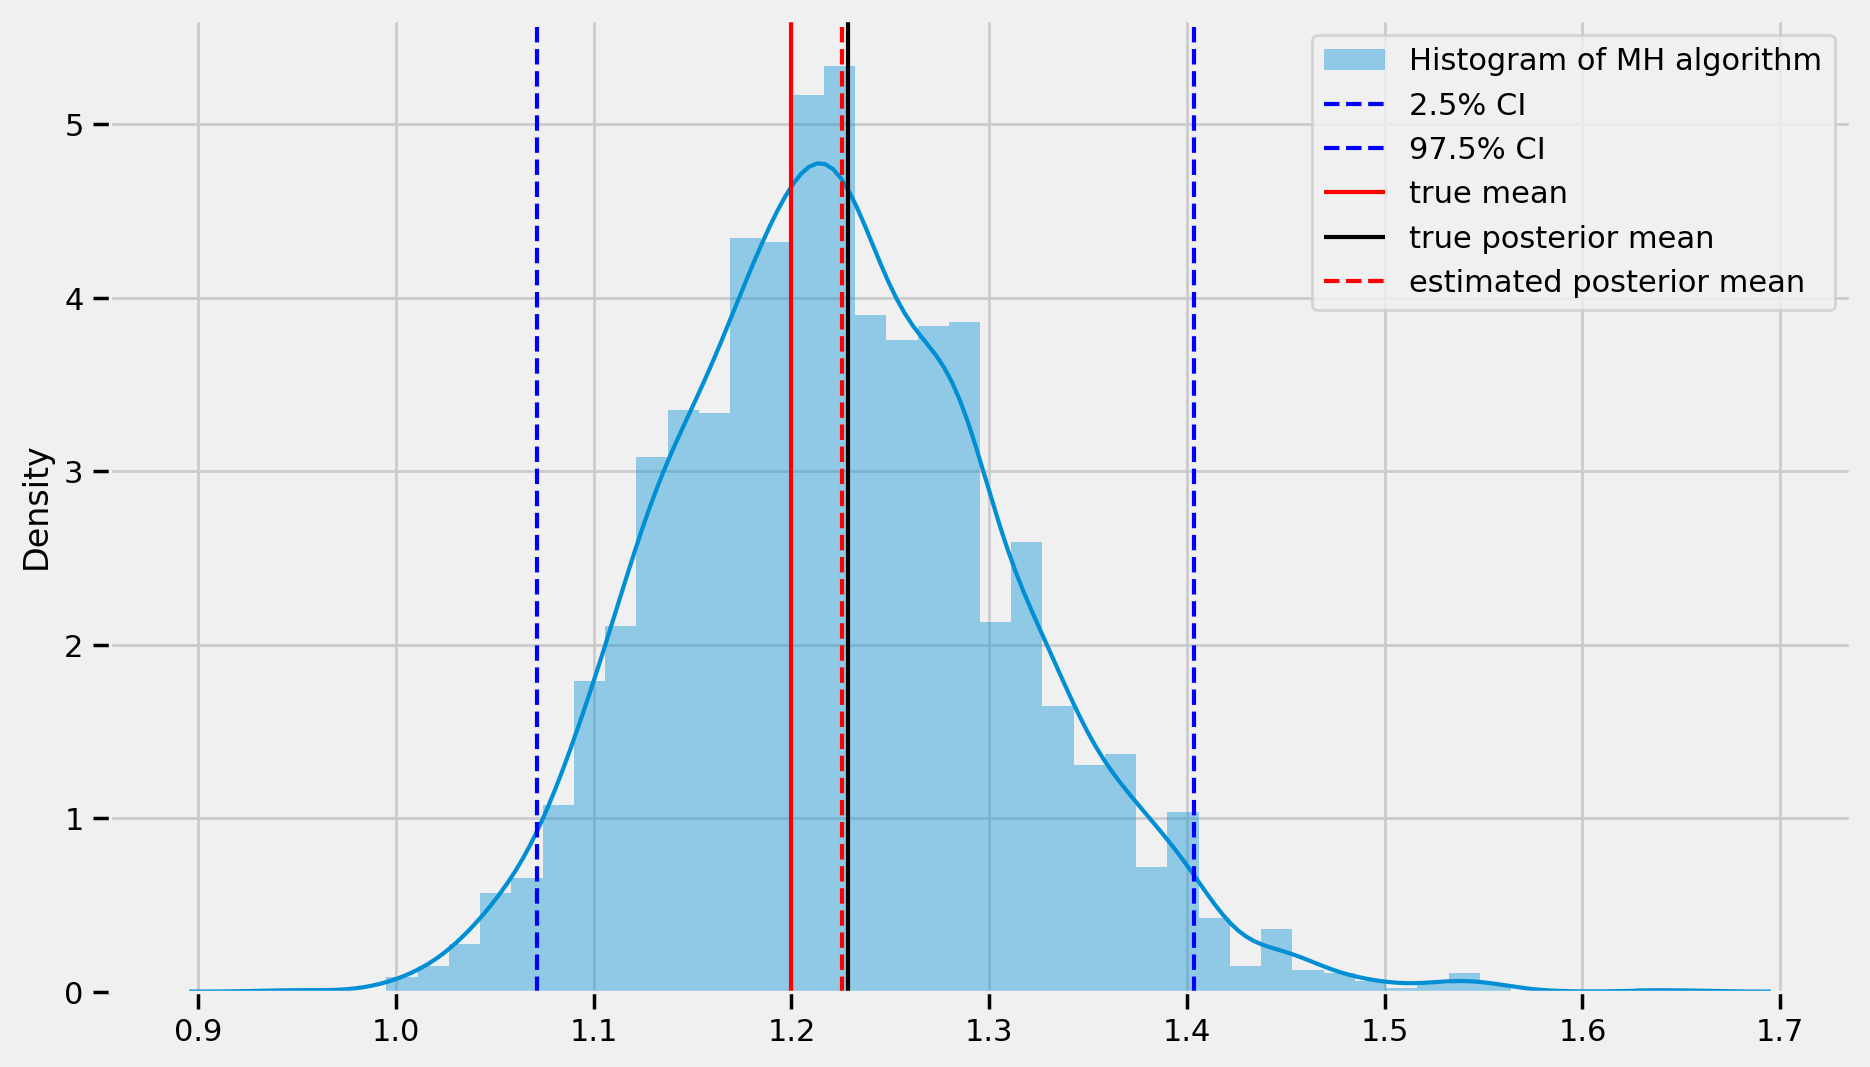

<ipython-input-9-30fd5d638ad5>:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


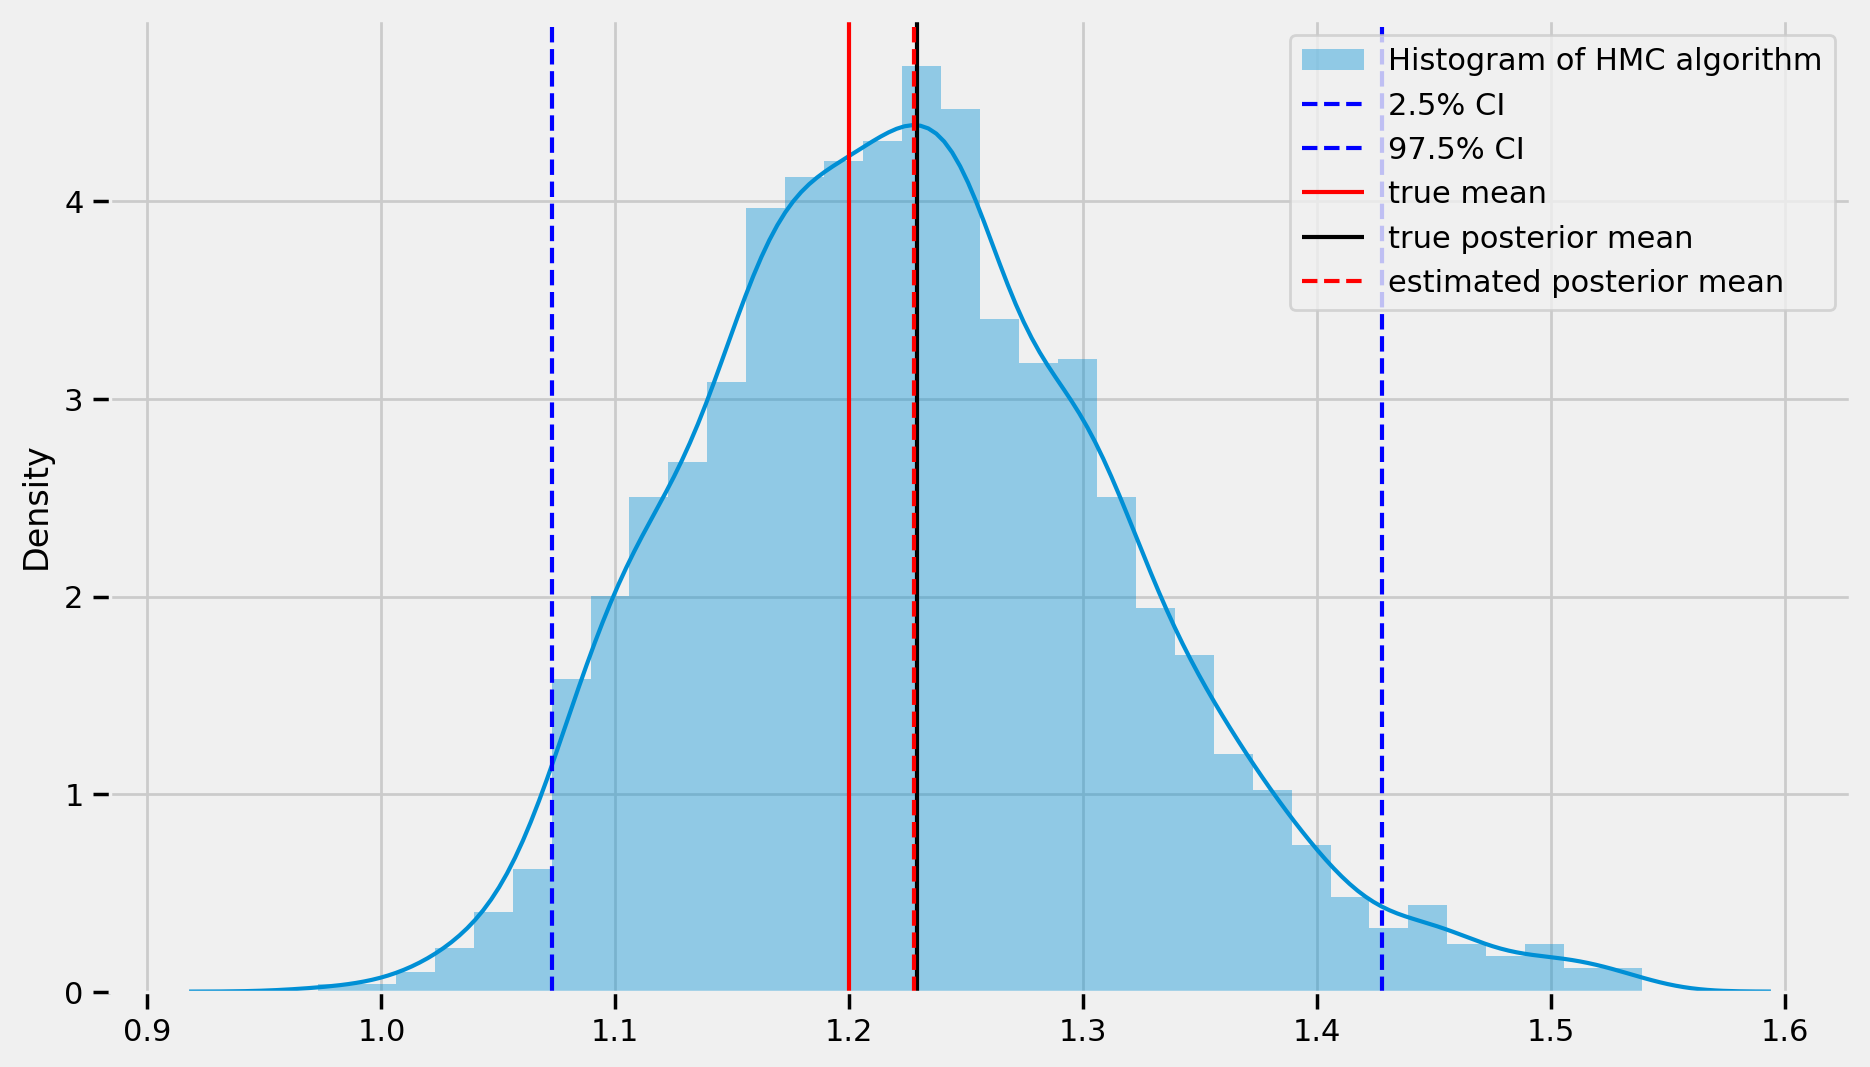

In [ ]:
plot_convergence(chain=0, state=0)

<ipython-input-9-30fd5d638ad5>:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


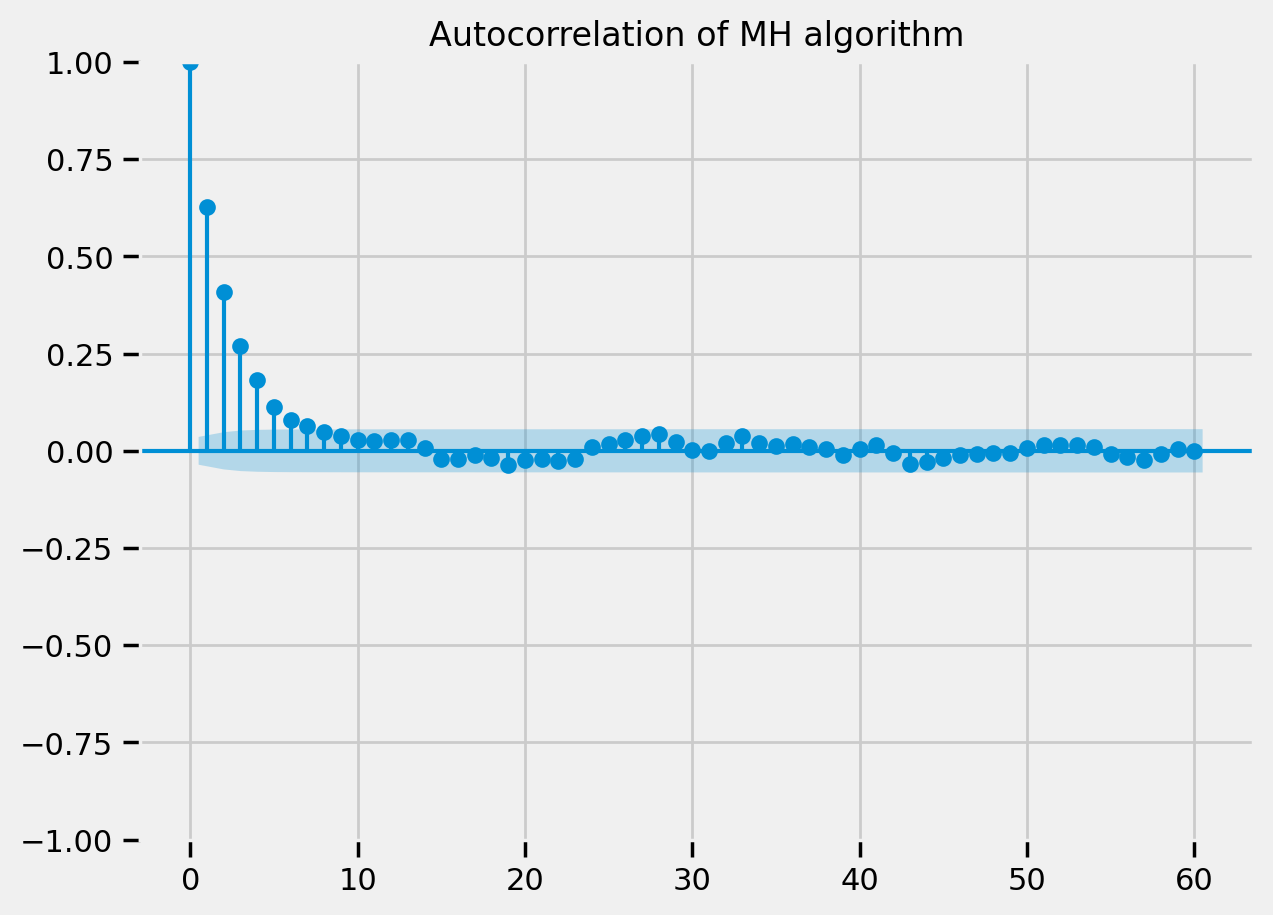

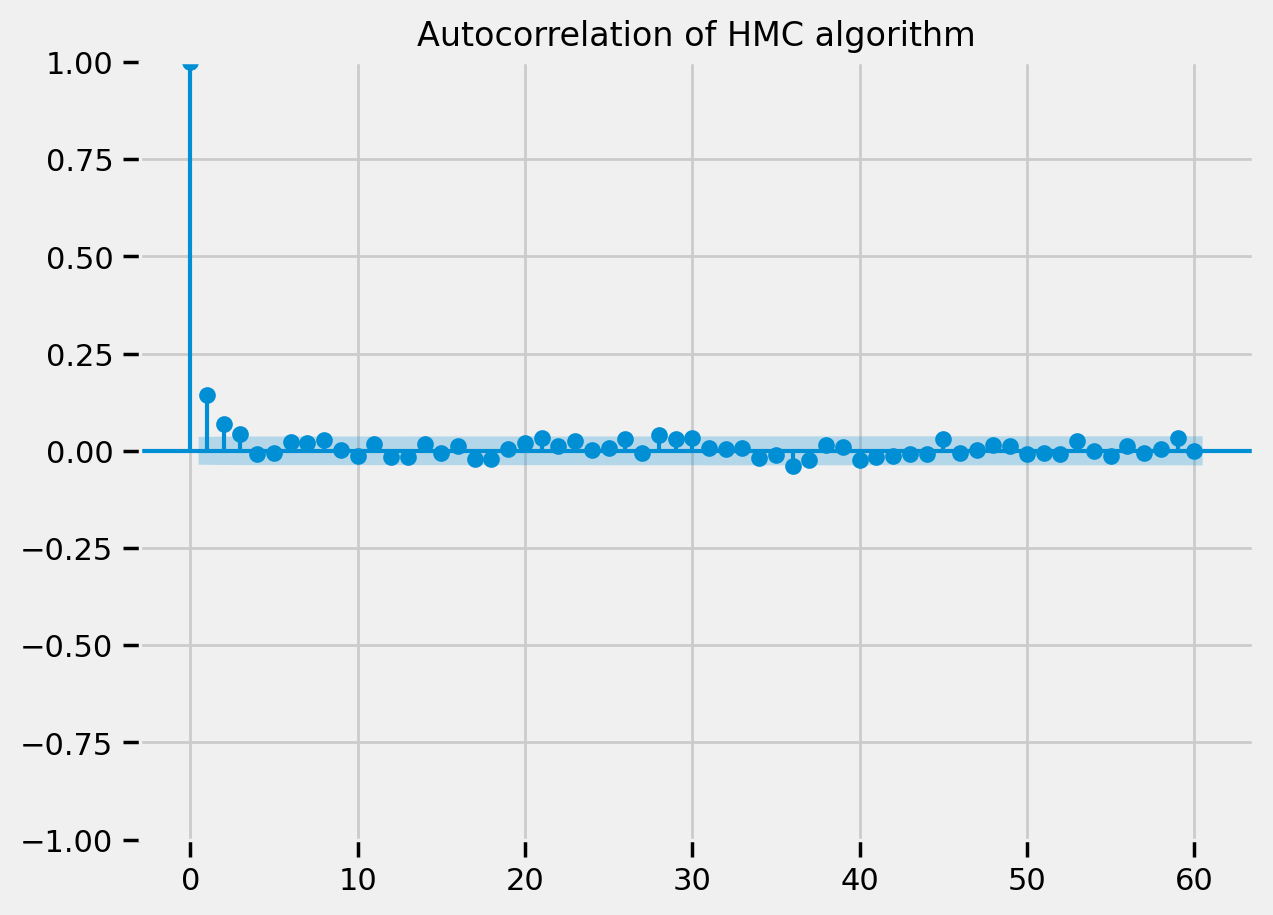

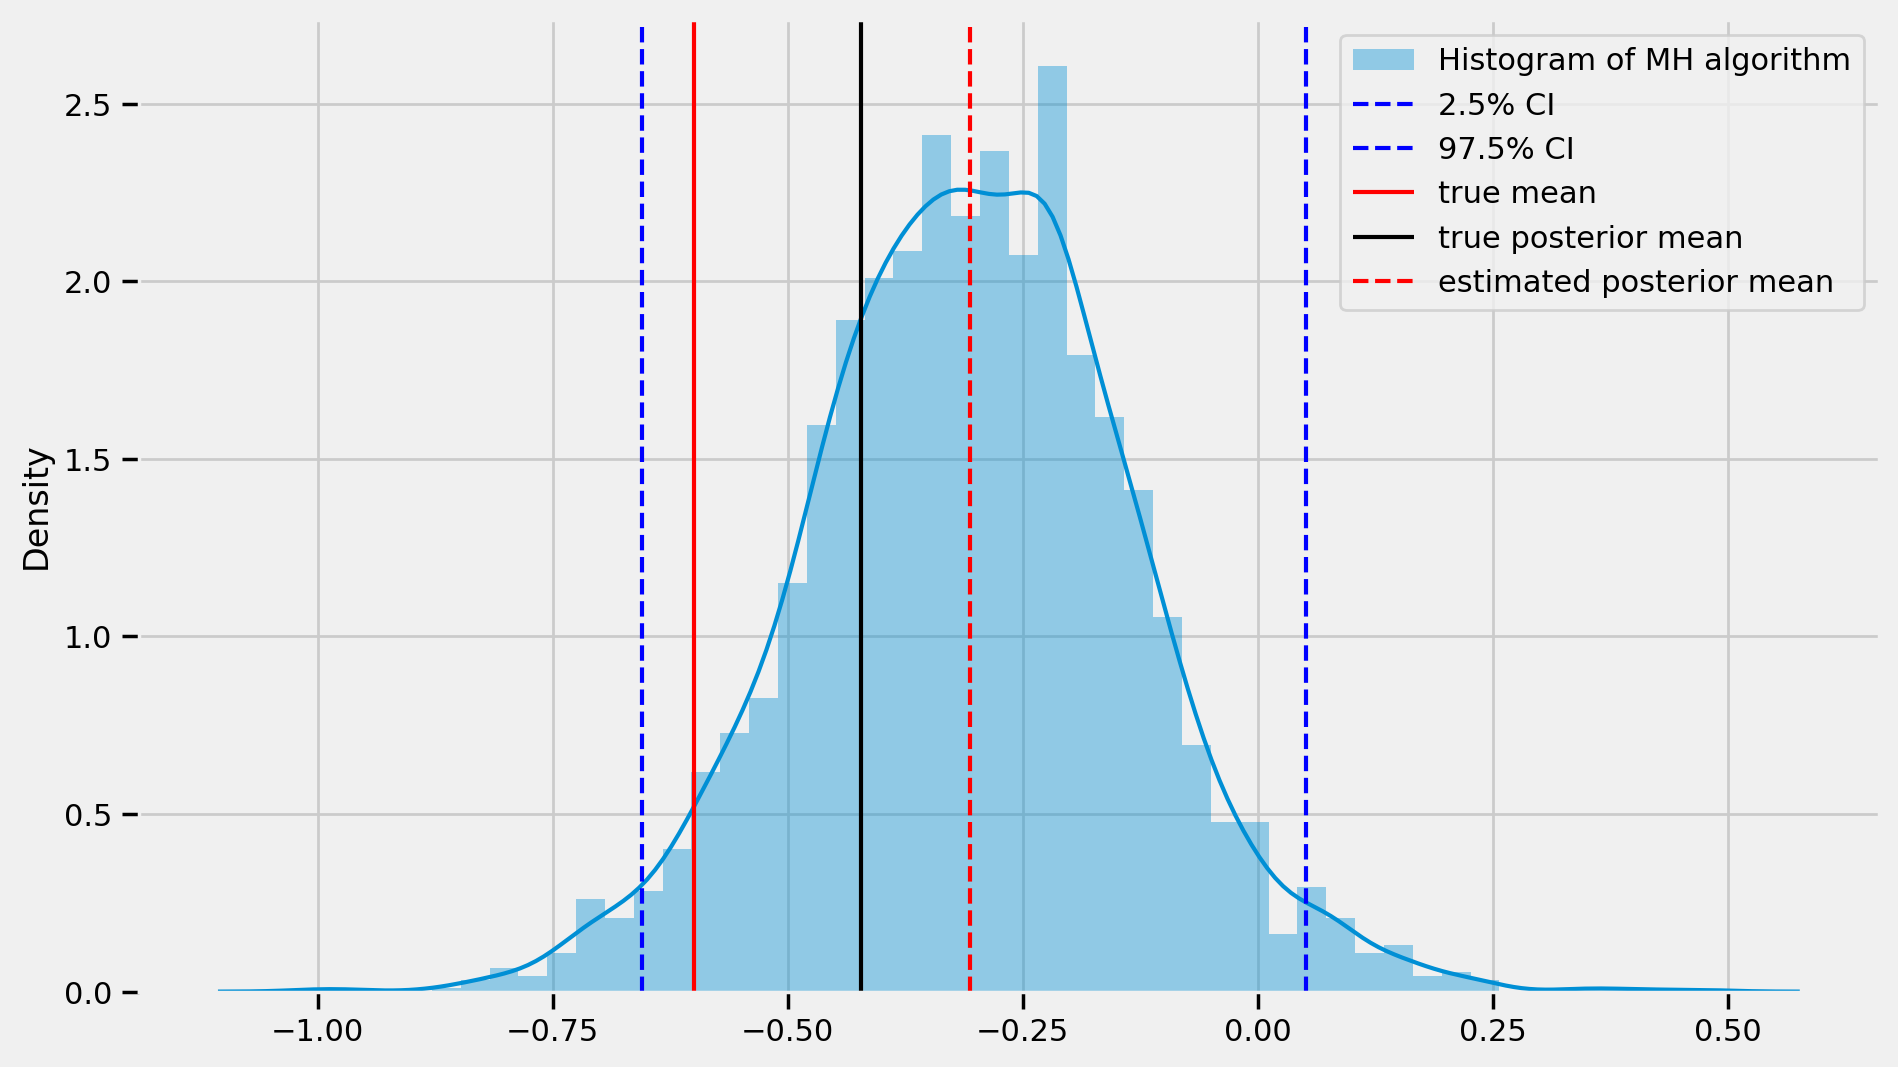

<ipython-input-9-30fd5d638ad5>:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


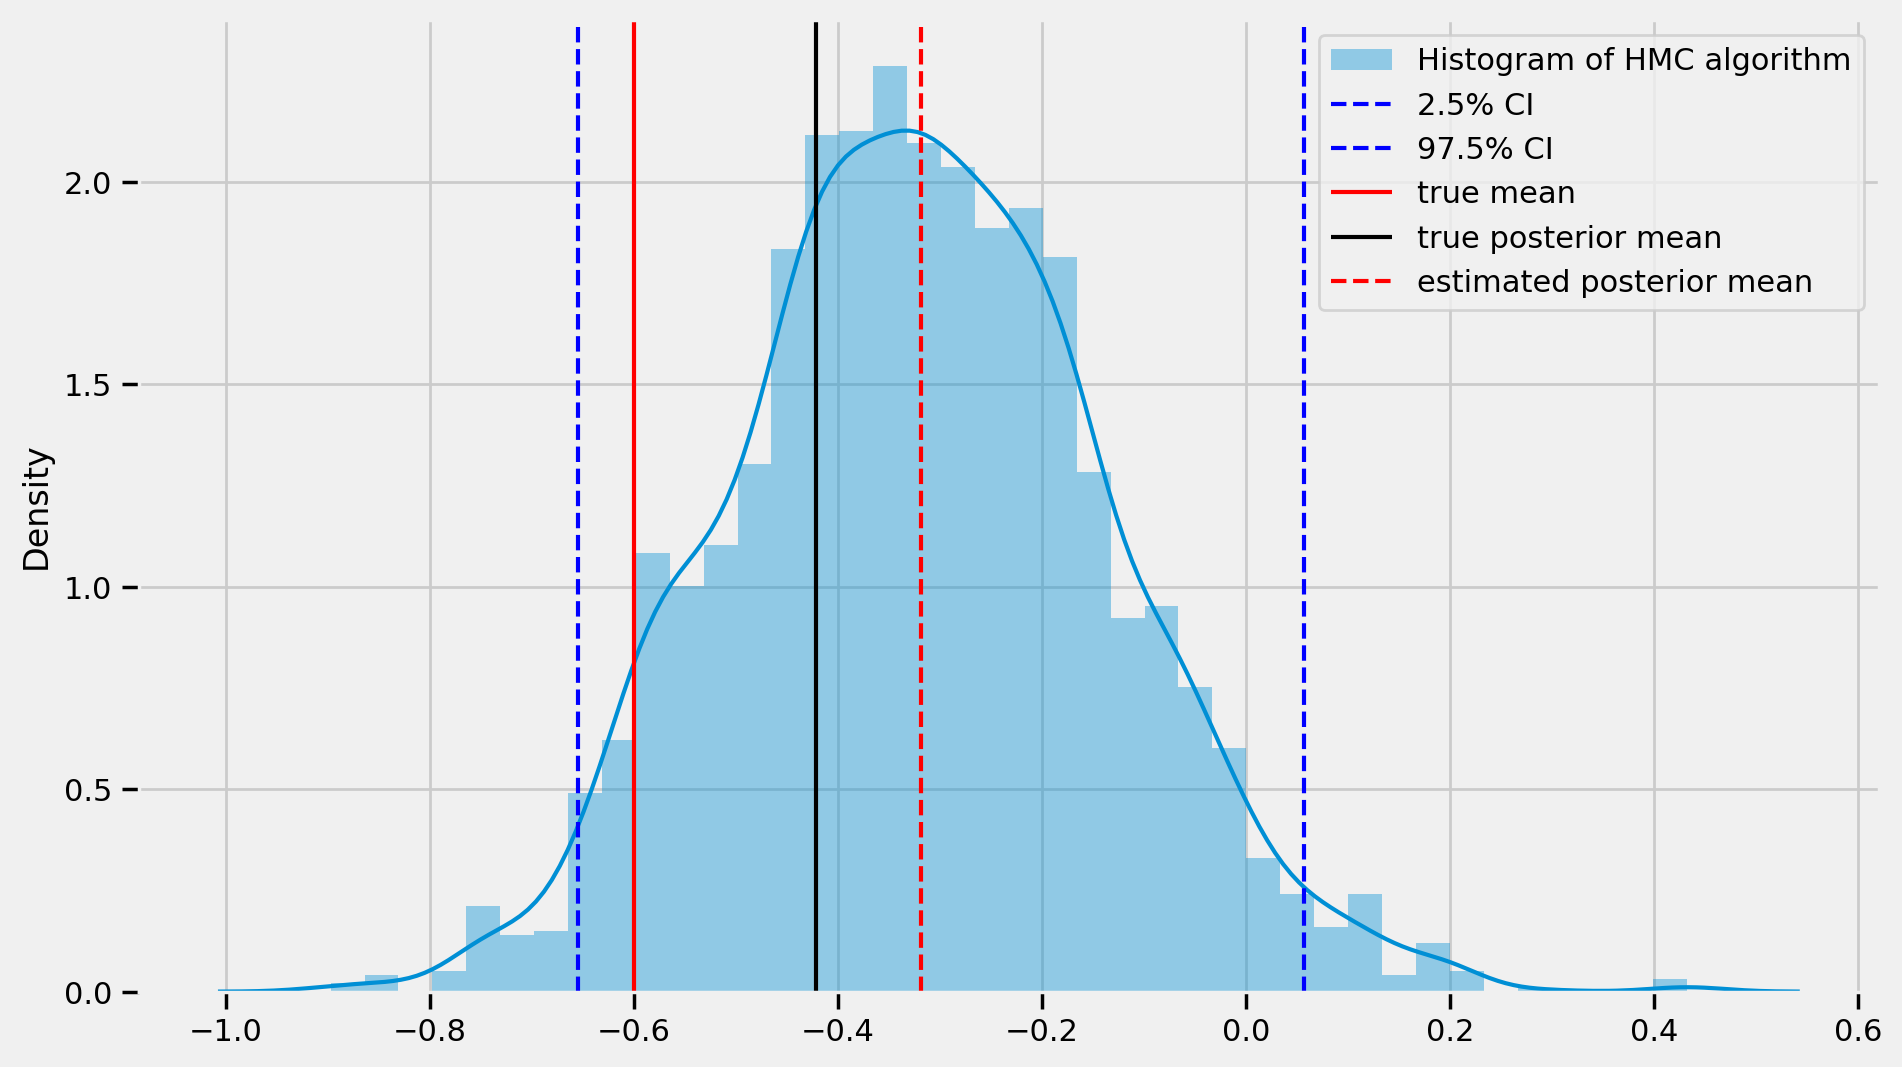

In [ ]:
plot_convergence(chain=0, state=1)

<ipython-input-9-30fd5d638ad5>:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


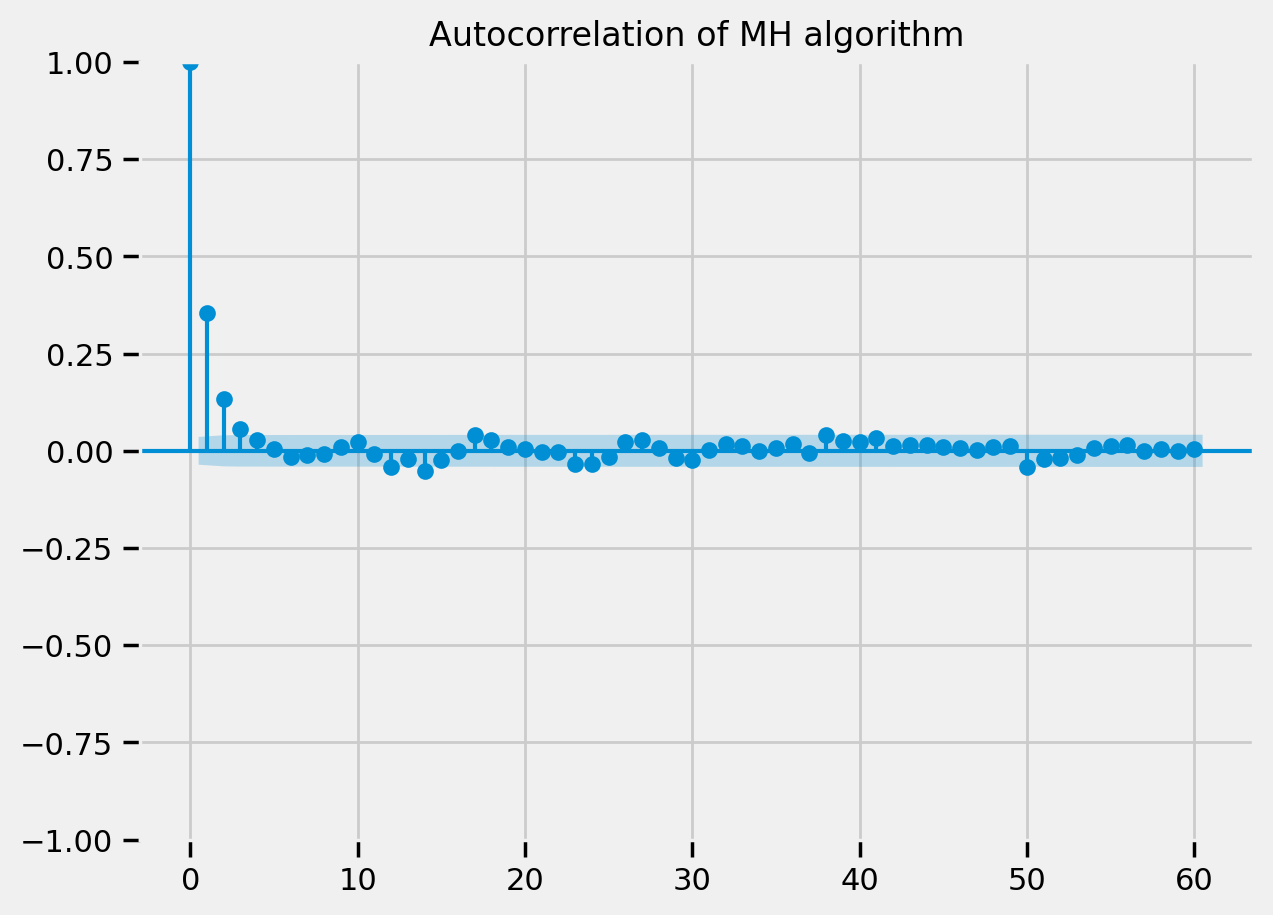

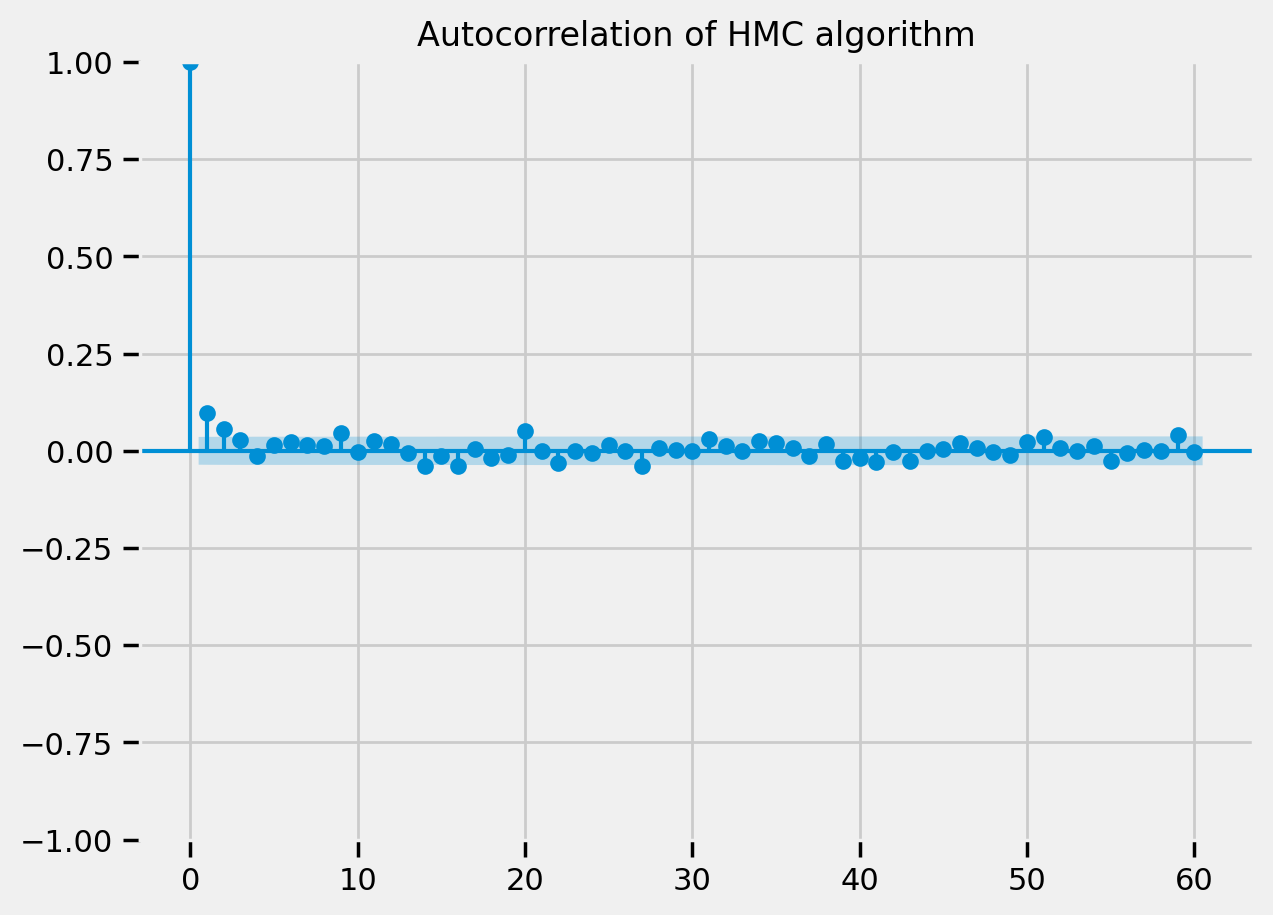

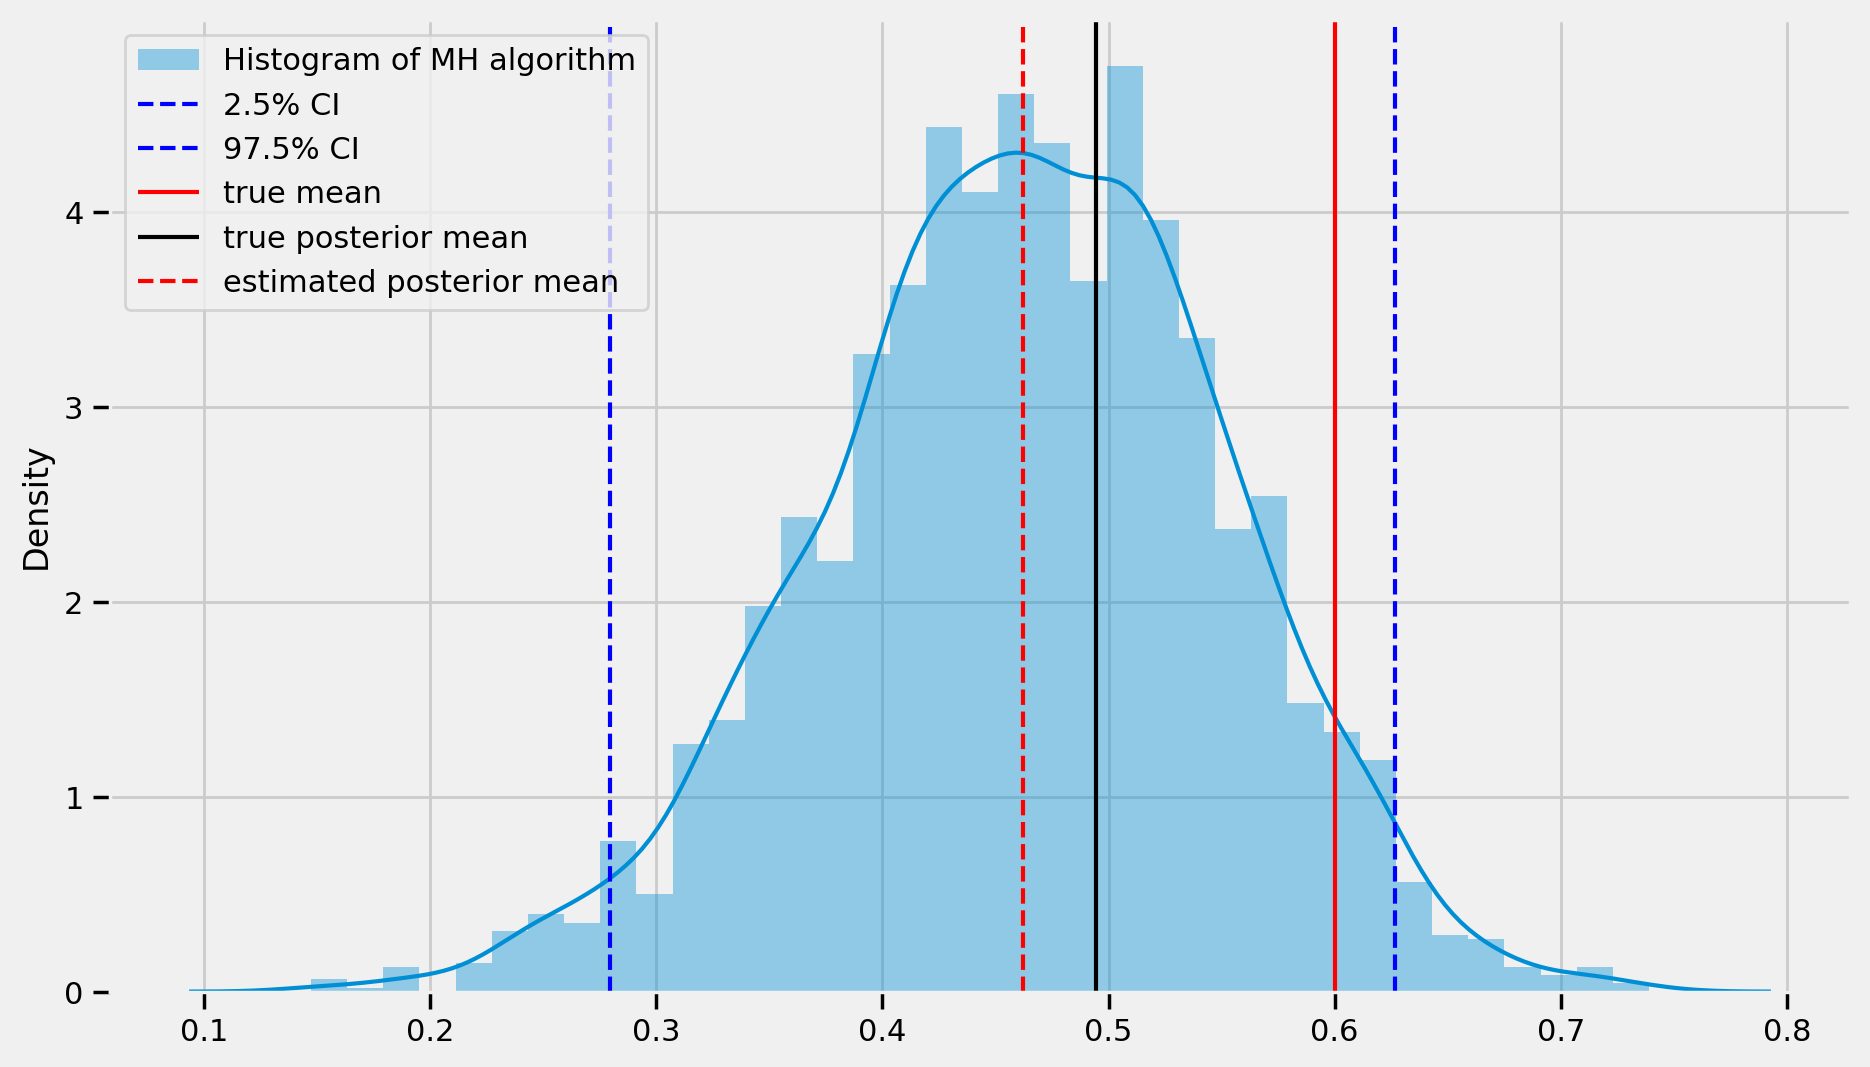

<ipython-input-9-30fd5d638ad5>:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


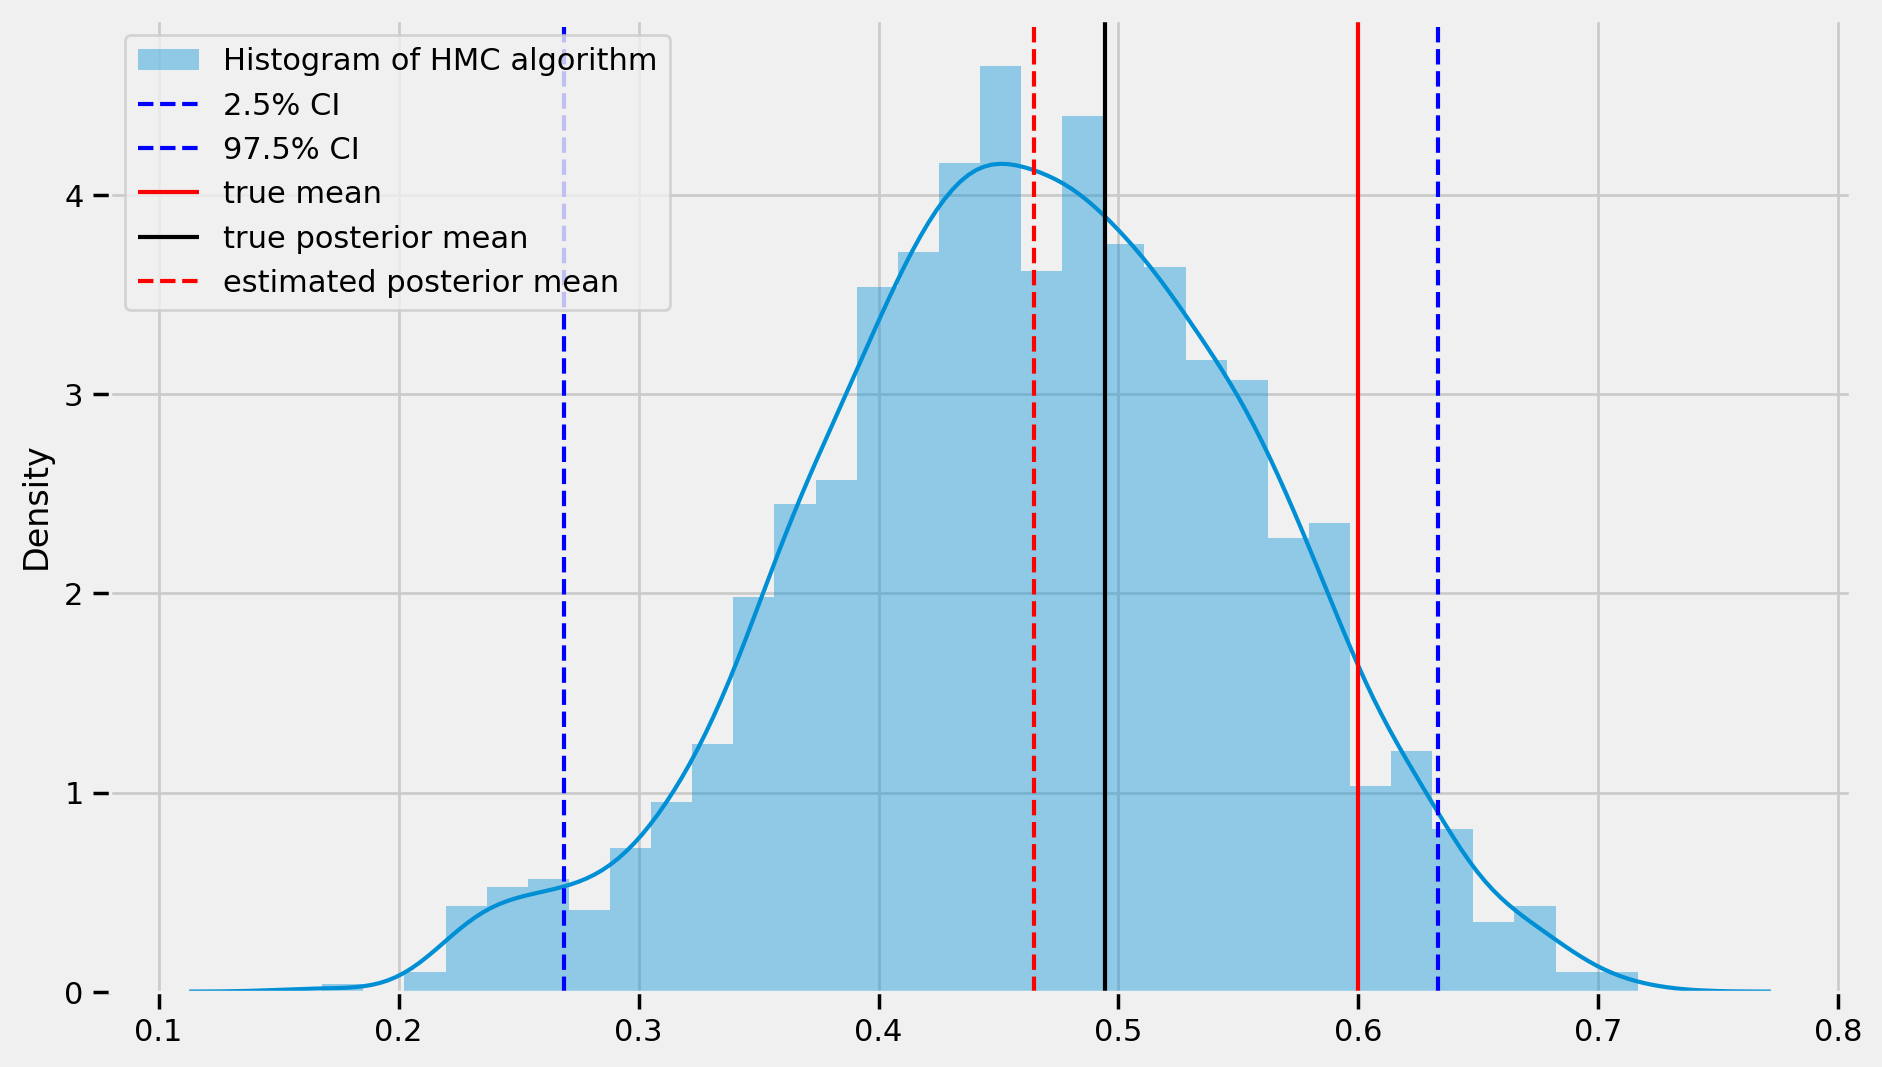

In [ ]:
plot_convergence(chain=0, state=2)

### Full-conditional For Gibbs sampling

Although it is possible to estimate 3 parameters with joint positerior distribution with MH and HMC, it is difficult to search the correct parameters in  high dimension parametrized space. Another simplier idea is to conduct the Gibbs sampling to update the parameters sequentially with full conditional posterior distribution. Since every parameter is partially related to other parameters, it is relatively easier to factorize the posterior distribution.

Recall that joint posterior distribution: $p(\sigma^2, \delta, \varphi|\mathbf{x}) ∝ l(\mathbf{x}| \sigma^2, \delta, \varphi)  \pi(\sigma^2)\pi(\delta)\pi(\varphi) $.

For $\varphi$, $p(\varphi|\mathbf{x}, \sigma^2, \delta, \mu) \sim l(\mathbf{x}|\mu, \sigma^2, \delta, \varphi) \mathcal{U}(-1, 1)$ which is a truncated normal distribution.

For $\sigma^2$,  $p(\sigma^2| \mathbf{x}, \delta, \mu, \varphi) \sim l(\mathbf{x}|\mu, \sigma^2, \delta, \varphi) \mathcal{IG}(\alpha, \beta)$ is a normal-inverse-Gamma distribution.

For the constant drift $\delta$,  $p(\delta|\mathbf{x}, \sigma^2, \mu, \varphi ) \sim l(\mathbf{x}|\mu, \sigma^2, \delta, \varphi) \mathcal{N}(\mu_0, \sigma_0^2)$ is a normal distribution.

In [ ]:
# @title Gibbs Sampling

"""
define conditional sampling distribution
"""

def delta_sample_fn(sampling_idx, current_state, rest_state_parts, seed=None):
  sigma = rest_state_parts[0]
  theta = rest_state_parts[1]
  coeff_delta = 1/PRIOR_STD_DELTA**2 + replicate_observations.shape[0]/sigma**2

  posterior_mean_delta = 1/coeff_delta*\
 (tf.reduce_sum(replicate_observations - theta*replicate_innovations)/sigma**2 + PRIOR_MEAN_DELTA/PRIOR_STD_DELTA**2)
  posterior_std = tf.sqrt(1 / coeff_delta)

  return tfd.MultivariateNormalTriL(loc=tf.squeeze(posterior_mean_delta, axis=-1),
                    scale_tril=posterior_std).sample(seed=seed)

def sigma_sample_fn(sampling_idx, current_state, rest_state_parts, seed=None):
  delta = rest_state_parts[0]
  theta = rest_state_parts[1]
  posterior_alpha = PRIOR_INV_GAMMA_ALPHA + replicate_observations.shape[0]//2
  posterior_beta = PRIOR_INV_GAMMA_BETA + \
      tf.reduce_sum((replicate_observations - (theta*replicate_innovations+delta))**2, axis=0)//2

  return tf.sqrt(tfd.InverseGamma(concentration=posterior_alpha,
                          scale=posterior_beta).sample(seed=seed))[..., tf.newaxis]

def theta_sample_fn(sampling_idx, current_state, rest_state_parts, seed=None):
  sigma = rest_state_parts[0]
  delta = rest_state_parts[1]
  sum_xt2 = tf.reduce_sum(replicate_innovations**2, axis=0)
  sum_xt = tf.reduce_sum(replicate_innovations*(replicate_observations - delta), axis=0)
  posterior_mean = sum_xt/sum_xt2
  posterior_std = 1/tf.sqrt(sum_xt2)
  return tfd.TruncatedNormal(loc=posterior_mean,
                          scale=posterior_std,
                             low=-0.99,
                             high=0.99).sample(seed=seed)

def kernel_make_fn_delta(target_log_prob_fn, states, state_part_idx):
    return SamplingKernel(target_log_prob_fn=target_log_prob_fn,
                                      full_cond_dist=cond_sample_fn(delta_sample_fn),
                                      sampling_idx=state_part_idx,
                                        current_full_states=states)

def kernel_make_fn_sigma(target_log_prob_fn, states, state_part_idx):
    return SamplingKernel(target_log_prob_fn=target_log_prob_fn,
                                      full_cond_dist=cond_sample_fn(sigma_sample_fn),
                                      sampling_idx=state_part_idx,
                                        current_full_states=states)

def kernel_make_fn_theta(target_log_prob_fn, states, state_part_idx):
    return SamplingKernel(target_log_prob_fn=target_log_prob_fn,
                                      full_cond_dist=cond_sample_fn(theta_sample_fn),
                                      sampling_idx=state_part_idx,
                                        current_full_states=states)


"""
define prior distribution
"""
def prior_dist(sigma, delta, theta):
  return tf.squeeze(tfd.InverseGamma(concentration=PRIOR_INV_GAMMA_ALPHA,
                                  scale=PRIOR_INV_GAMMA_BETA).log_prob(sigma[..., 0])) + \
        tfd.MultivariateNormalTriL(loc=PRIOR_MEAN_DELTA, scale_tril=PRIOR_STD_DELTA).log_prob(delta) + \
         tf.squeeze(tfd.Uniform(low=-0.99, high=0.99).log_prob(theta))


"""
define target distribution
"""
def posterior_dist(observations):
    def _compute_posterior(sigma, delta, theta):
        # use tf.vector_map to speed up
        estimated_noise = tf.scan(fn=lambda a, x: x - a * theta - delta,
                                elems=replicate_observations,
                                initializer=tf.zeros([N_CHAINS, 1]),
                                parallel_iterations=20)
        estimated_noise = tf.concat([tf.zeros([1, N_CHAINS, 1]), estimated_noise[:-1, ...]], axis=0)

        data_std = sigma
        likelihood = tfd.MultivariateNormalTriL(loc=theta*estimated_noise+delta,
                                                        scale_tril=data_std).log_prob(observations)
        return tf.reduce_sum(likelihood, axis=0) + prior_dist(sigma, delta, theta)

    return _compute_posterior

"""
Sampling
"""

@tf.function
def run_gibbs_sampling():
  kernel_list = [(0, kernel_make_fn_sigma),
                   (1, kernel_make_fn_delta),
                 (2, kernel_make_fn_theta)]
  kernel = GibbsKernel(
        target_log_prob_fn=posterior_dist(replicate_observations),
        kernel_list=kernel_list
    )

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                           current_state=[tf.random.uniform([N_CHAINS, 1, 1]),
                                                          tf.random.normal([N_CHAINS, 1]),
                                                          tf.random.uniform([N_CHAINS, 1])-0.5],
                                           num_burnin_steps=num_burn_in_steps,
                                           kernel=kernel,
                                           seed=seed)
  return states, kernels_results

gibbs_states, gibbs_results = run_gibbs_sampling()

gibbs_states_sigma = tf.squeeze(gibbs_states[0], axis=-1).numpy()
gibbs_states_delta = tf.squeeze(gibbs_states[1], axis=-1).numpy()
gibbs_states_theta = tf.squeeze(gibbs_states[2], axis=-1).numpy()



/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [ ]:
#@title Diagonics For Signal Variance

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    gibbs_states_sigma,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for Gibbs algorithm {r_hat_mh}")

ess_mh = tfp.mcmc.effective_sample_size(
    gibbs_states_sigma,
    cross_chain_dims=None,
)

print(f"Effective sample size for Gibbs algorithm {ess_mh}")



<ipython-input-15-e4417decb486>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')


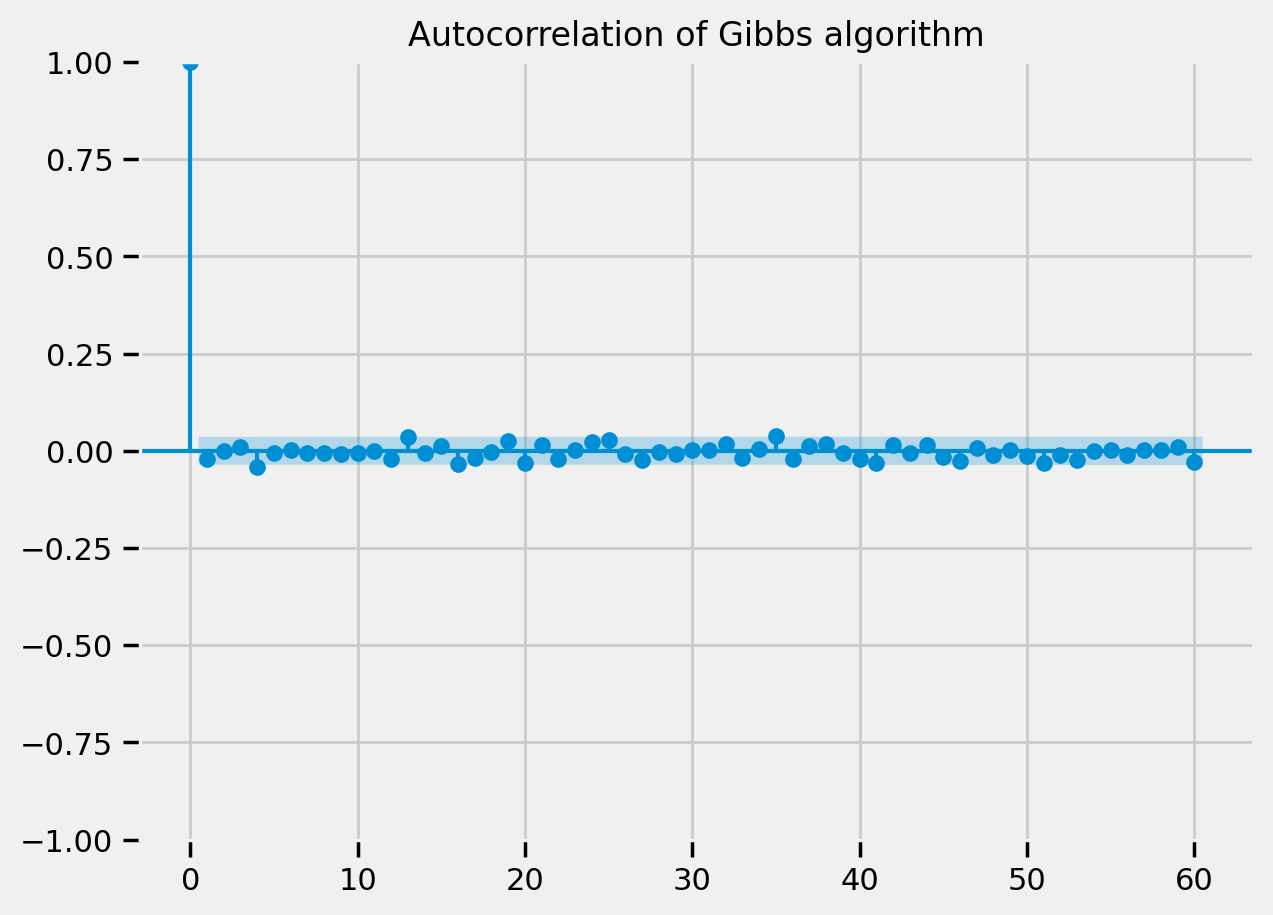

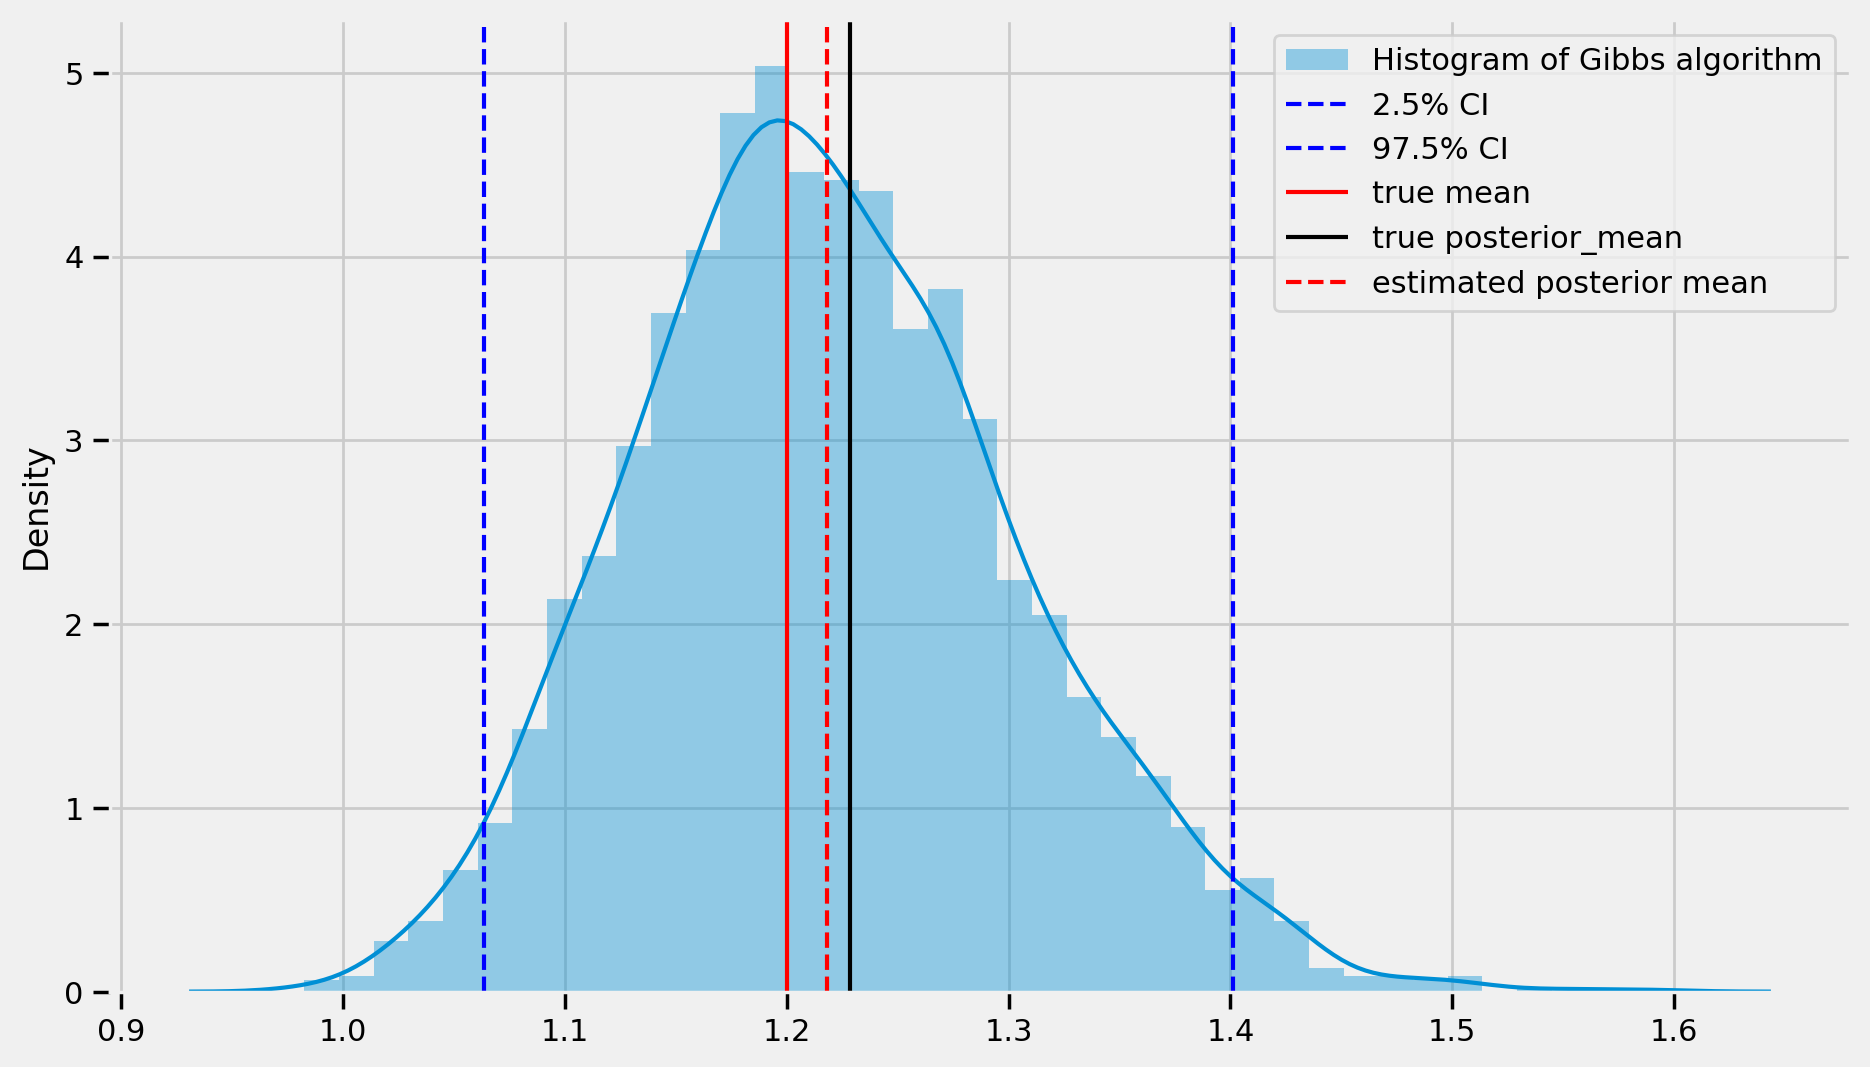

In [ ]:
# use the first chain for plotting auto-correlation
sm.graphics.tsa.plot_acf(gibbs_states_sigma[:, 0],
                         title='Autocorrelation of Gibbs algorithm',
                         lags=60)

# plot the fist chain

mh_dist = gibbs_states_sigma[:, 0]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_noise_std, color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_sigma_mean, color='black', linestyle='-', label='true posterior_mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


In [ ]:
#@title Diagonics For $\delta$

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    gibbs_states_delta,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for Gibbs algorithm {r_hat_mh}")

ess_mh = tfp.mcmc.effective_sample_size(
    gibbs_states_delta,
    cross_chain_dims=None,
)

print(f"Effective sample size for Gibbs algorithm {ess_mh}")



R^hat for Gibbs algorithm 1.0008933544158936
Effective sample size for Gibbs algorithm [2883.487]


<ipython-input-17-c17e33572833>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')


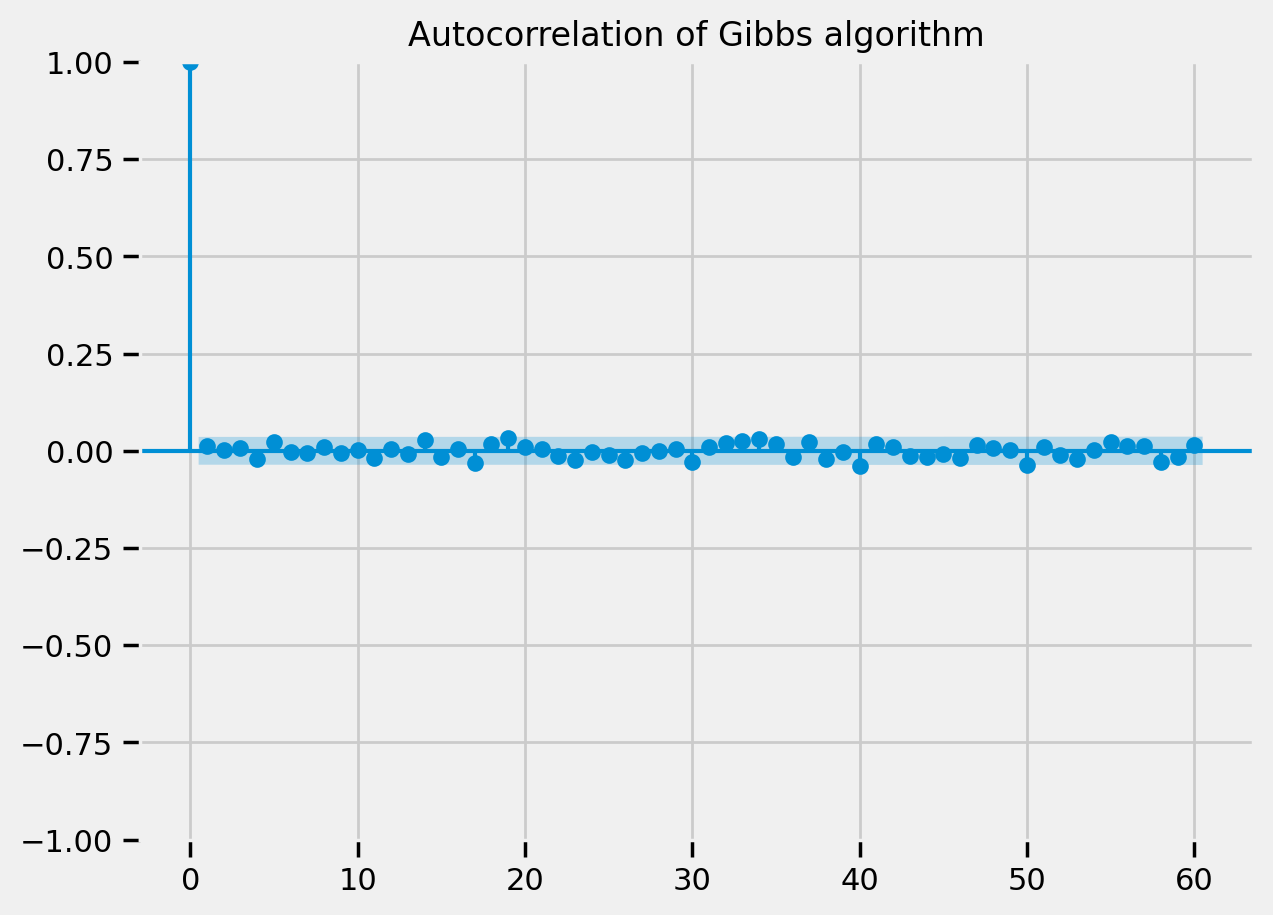

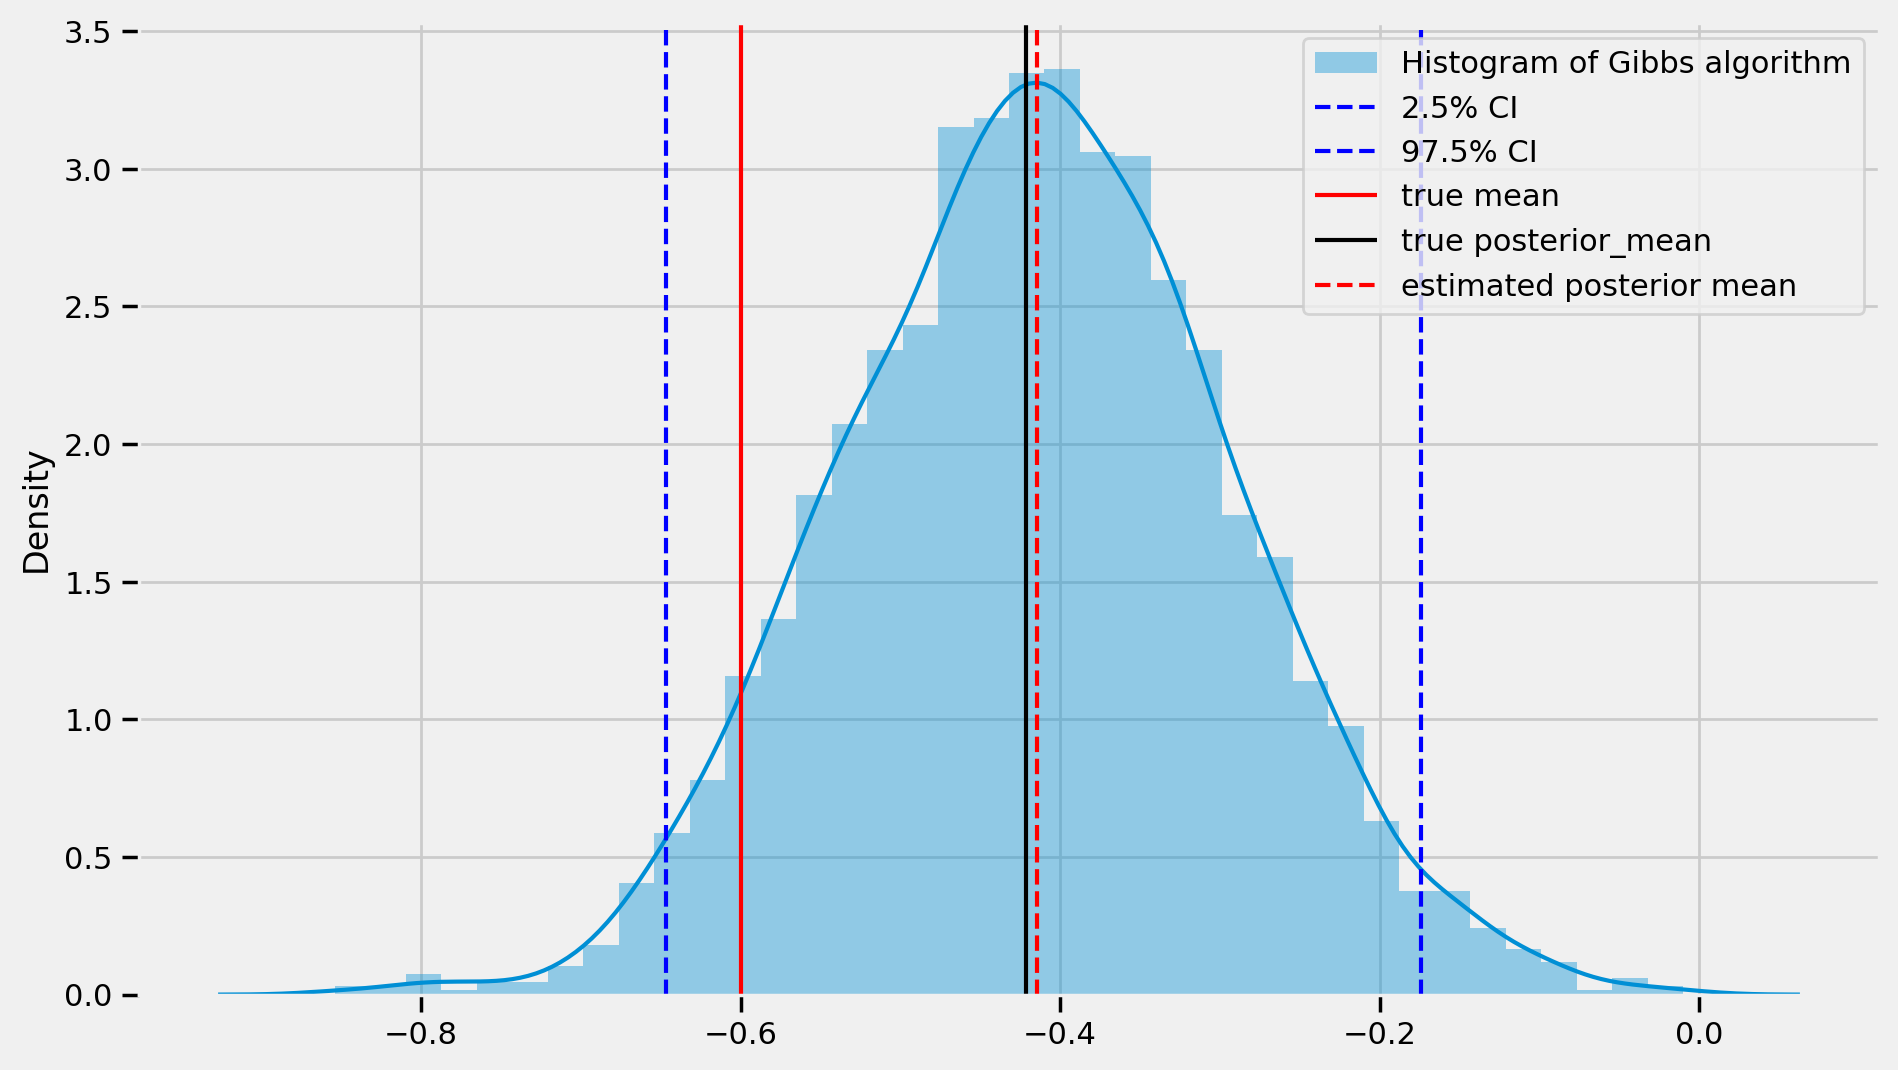

In [ ]:
# use the first chain for plotting auto-correlation
sm.graphics.tsa.plot_acf(gibbs_states_delta[:, 0],
                         title='Autocorrelation of Gibbs algorithm',
                         lags=60)

# plot the fist chain

mh_dist = gibbs_states_delta[:, 0]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_delta, color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_mean_delta, color='black', linestyle='-', label='true posterior_mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


In [ ]:
#@title Diagonics For $\theta$

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    gibbs_states_theta,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for Gibbs algorithm {r_hat_mh}")

ess_mh = tfp.mcmc.effective_sample_size(
    gibbs_states_theta,
    cross_chain_dims=None,
)

print(f"Effective sample size for Gibbs algorithm {ess_mh}")



R^hat for Gibbs algorithm 1.0008102655410767
Effective sample size for Gibbs algorithm [3000.]


<ipython-input-19-0fce50707d31>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')


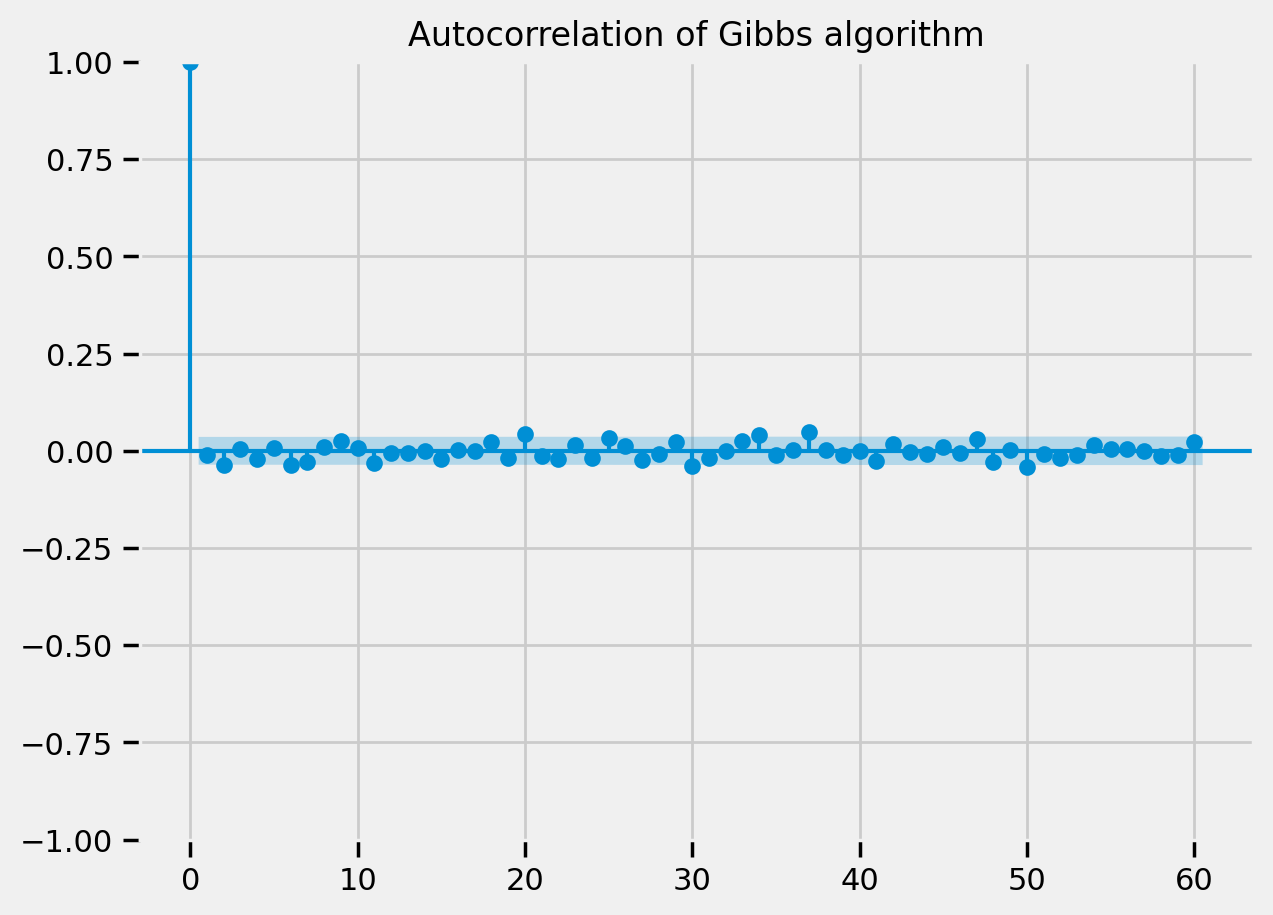

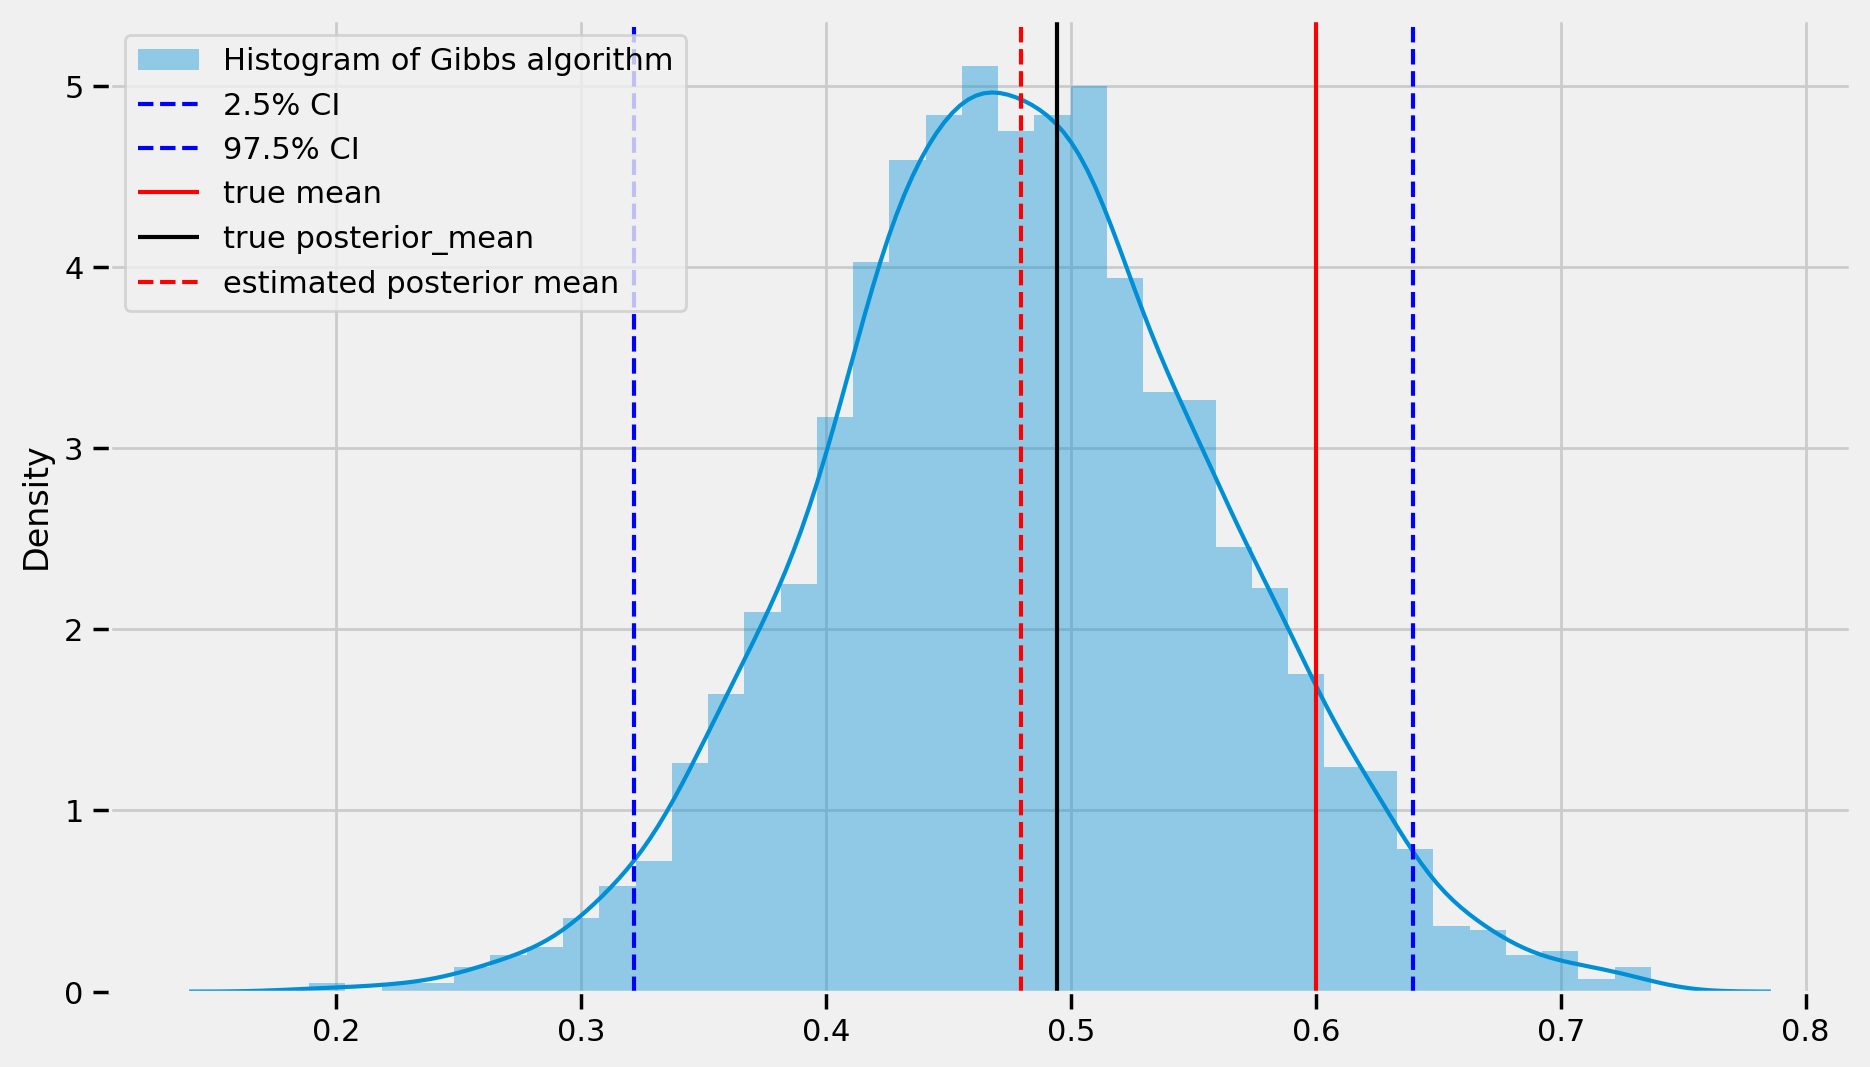

In [ ]:
# use the first chain for plotting auto-correlation
sm.graphics.tsa.plot_acf(gibbs_states_theta[:, 0],
                         title='Autocorrelation of Gibbs algorithm',
                         lags=60)

# plot the fist chain

mh_dist = gibbs_states_theta[:, 0]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(mh_dist, ax=ax, label='Histogram of Gibbs algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_theta, color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_mean_theta, color='black', linestyle='-', label='true posterior_mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()
